# Baseline CNN for Dogs vs Cats

Simple CNN baseline to establish a starting point.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.1 GB


In [2]:
# Set paths
train_dir = '/home/data/train'
test_dir = '/home/data/test'
sample_submission_path = '/home/data/sample_submission.csv'

# Get all training images
train_files = os.listdir(train_dir)
train_files = [f for f in train_files if f.endswith('.jpg')]

print(f"Total training images: {len(train_files)}")

# Create labels (1 for dog, 0 for cat)
train_labels = []
train_paths = []

for file in train_files:
    if file.startswith('dog'):
        train_labels.append(1)
        train_paths.append(os.path.join(train_dir, file))
    elif file.startswith('cat'):
        train_labels.append(0)
        train_paths.append(os.path.join(train_dir, file))

print(f"Dogs: {sum(train_labels)}")
print(f"Cats: {len(train_labels) - sum(train_labels)}")

Total training images: 22500
Dogs: 11258
Cats: 11242


In [3]:
# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_paths, train_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=train_labels
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Training dogs: {sum(y_train)}")
print(f"Validation dogs: {sum(y_val)}")

Training samples: 18000
Validation samples: 4500
Training dogs: 9006
Validation dogs: 2252


In [5]:
# Define dataset class
class DogsCatsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[idx]
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create datasets and dataloaders
train_dataset = DogsCatsDataset(X_train, y_train, transform=train_transform)
val_dataset = DogsCatsDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 563
Validation batches: 141


In [7]:
# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate feature size after convolutions
        # Input: 128x128 -> pool -> 64x64 -> pool -> 32x32 -> pool -> 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 128x128 -> 64x64
        x = self.pool(torch.relu(self.conv2(x)))  # 64x64 -> 32x32
        x = self.pool(torch.relu(self.conv3(x)))  # 32x32 -> 16x16
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = SimpleCNN()
if torch.cuda.is_available():
    model = model.cuda()
    
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size (MB): {sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024:.2f}")

Model parameters: 16,871,489
Model size (MB): 64.36


In [8]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images = images.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), correct / total

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images = images.to(device)
            labels = labels.float().to(device)
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(loader), correct / total, all_probs, all_labels

# Calculate log loss
def log_loss(probs, labels):
    probs = np.array(probs)
    labels = np.array(labels)
    eps = 1e-15
    probs = np.clip(probs, eps, 1 - eps)
    return -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))

In [10]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = 0
best_log_loss = float('inf')

train_losses = []
val_losses = []
val_accs = []
val_log_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_probs, val_labels = validate_epoch(model, val_loader, criterion, device)
    val_logloss = log_loss(val_probs, val_labels)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_log_losses.append(val_logloss)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val LogLoss: {val_logloss:.4f}")
    
    # Save best model
    if val_logloss < best_log_loss:
        best_log_loss = val_logloss
        torch.save(model.state_dict(), '/home/code/models/baseline_cnn_best.pth')
        print(f"New best model saved with LogLoss: {val_logloss:.4f}")


Epoch 1/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:46,  5.28it/s]

Training:   1%|          | 5/563 [00:00<00:36, 15.30it/s]

Training:   2%|▏         | 9/563 [00:00<00:30, 18.38it/s]

Training:   2%|▏         | 12/563 [00:00<00:25, 21.43it/s]

Training:   3%|▎         | 15/563 [00:00<00:26, 20.44it/s]

Training:   3%|▎         | 18/563 [00:00<00:25, 21.75it/s]

Training:   4%|▎         | 21/563 [00:01<00:26, 20.85it/s]

Training:   4%|▍         | 24/563 [00:01<00:24, 21.71it/s]

Training:   5%|▍         | 27/563 [00:01<00:24, 21.57it/s]

Training:   5%|▌         | 30/563 [00:01<00:24, 21.41it/s]

Training:   6%|▌         | 33/563 [00:01<00:24, 21.57it/s]

Training:   6%|▋         | 36/563 [00:01<00:25, 20.91it/s]

Training:   7%|▋         | 39/563 [00:01<00:24, 21.78it/s]

Training:   7%|▋         | 42/563 [00:02<00:25, 20.36it/s]

Training:   8%|▊         | 45/563 [00:02<00:23, 21.90it/s]

Training:   9%|▊         | 48/563 [00:02<00:25, 20.02it/s]

Training:   9%|▉         | 51/563 [00:02<00:23, 21.40it/s]

Training:  10%|▉         | 54/563 [00:02<00:26, 19.54it/s]

Training:  10%|█         | 57/563 [00:02<00:23, 21.63it/s]

Training:  11%|█         | 60/563 [00:02<00:25, 19.50it/s]

Training:  11%|█         | 63/563 [00:03<00:23, 21.31it/s]

Training:  12%|█▏        | 66/563 [00:03<00:25, 19.67it/s]

Training:  12%|█▏        | 69/563 [00:03<00:22, 21.61it/s]

Training:  13%|█▎        | 72/563 [00:03<00:24, 19.65it/s]

Training:  13%|█▎        | 75/563 [00:03<00:22, 21.83it/s]

Training:  14%|█▍        | 78/563 [00:03<00:23, 20.37it/s]

Training:  15%|█▍        | 82/563 [00:03<00:22, 21.30it/s]

Training:  15%|█▌        | 86/563 [00:04<00:21, 21.75it/s]

Training:  16%|█▌        | 89/563 [00:04<00:20, 23.46it/s]

Training:  16%|█▋        | 92/563 [00:04<00:21, 21.64it/s]

Training:  17%|█▋        | 95/563 [00:04<00:19, 23.44it/s]

Training:  17%|█▋        | 98/563 [00:04<00:21, 21.64it/s]

Training:  18%|█▊        | 102/563 [00:04<00:21, 21.53it/s]

Training:  19%|█▊        | 105/563 [00:04<00:19, 23.27it/s]

Training:  19%|█▉        | 108/563 [00:05<00:21, 21.19it/s]

Training:  20%|█▉        | 112/563 [00:05<00:21, 21.45it/s]

Training:  20%|██        | 115/563 [00:05<00:19, 23.21it/s]

Training:  21%|██        | 118/563 [00:05<00:20, 21.39it/s]

Training:  21%|██▏       | 121/563 [00:05<00:19, 22.94it/s]

Training:  22%|██▏       | 124/563 [00:05<00:20, 21.54it/s]

Training:  23%|██▎       | 128/563 [00:06<00:20, 21.75it/s]

Training:  23%|██▎       | 132/563 [00:06<00:19, 21.87it/s]

Training:  24%|██▍       | 135/563 [00:06<00:18, 23.51it/s]

Training:  25%|██▍       | 138/563 [00:06<00:19, 21.52it/s]

Training:  25%|██▌       | 142/563 [00:06<00:19, 21.85it/s]

Training:  26%|██▌       | 146/563 [00:06<00:18, 22.19it/s]

Training:  27%|██▋       | 150/563 [00:07<00:18, 22.47it/s]

Training:  27%|██▋       | 153/563 [00:07<00:17, 23.91it/s]

Training:  28%|██▊       | 156/563 [00:07<00:18, 22.02it/s]

Training:  28%|██▊       | 159/563 [00:07<00:17, 23.46it/s]

Training:  29%|██▉       | 162/563 [00:07<00:18, 21.48it/s]

Training:  29%|██▉       | 165/563 [00:07<00:17, 23.23it/s]

Training:  30%|██▉       | 168/563 [00:07<00:18, 21.27it/s]

Training:  31%|███       | 172/563 [00:08<00:17, 21.88it/s]

Training:  31%|███▏      | 176/563 [00:08<00:17, 22.11it/s]

Training:  32%|███▏      | 180/563 [00:08<00:17, 22.30it/s]

Training:  33%|███▎      | 184/563 [00:08<00:16, 22.58it/s]

Training:  33%|███▎      | 187/563 [00:08<00:15, 24.08it/s]

Training:  34%|███▎      | 190/563 [00:08<00:16, 22.15it/s]

Training:  34%|███▍      | 194/563 [00:09<00:16, 22.02it/s]

Training:  35%|███▌      | 198/563 [00:09<00:16, 22.26it/s]

Training:  36%|███▌      | 202/563 [00:09<00:16, 22.32it/s]

Training:  37%|███▋      | 206/563 [00:09<00:16, 22.23it/s]

Training:  37%|███▋      | 209/563 [00:09<00:14, 23.71it/s]

Training:  38%|███▊      | 212/563 [00:09<00:15, 21.94it/s]

Training:  38%|███▊      | 216/563 [00:09<00:15, 22.07it/s]

Training:  39%|███▉      | 220/563 [00:10<00:15, 22.30it/s]

Training:  40%|███▉      | 223/563 [00:10<00:14, 23.64it/s]

Training:  40%|████      | 226/563 [00:10<00:15, 21.50it/s]

Training:  41%|████      | 229/563 [00:10<00:14, 23.12it/s]

Training:  41%|████      | 232/563 [00:10<00:15, 21.39it/s]

Training:  42%|████▏     | 235/563 [00:10<00:14, 23.29it/s]

Training:  42%|████▏     | 238/563 [00:10<00:15, 21.36it/s]

Training:  43%|████▎     | 241/563 [00:11<00:13, 23.02it/s]

Training:  43%|████▎     | 244/563 [00:11<00:15, 21.19it/s]

Training:  44%|████▍     | 248/563 [00:11<00:14, 21.64it/s]

Training:  45%|████▍     | 251/563 [00:11<00:13, 23.46it/s]

Training:  45%|████▌     | 254/563 [00:11<00:14, 21.81it/s]

Training:  46%|████▌     | 257/563 [00:11<00:12, 23.66it/s]

Training:  46%|████▌     | 260/563 [00:11<00:14, 21.61it/s]

Training:  47%|████▋     | 263/563 [00:12<00:12, 23.30it/s]

Training:  47%|████▋     | 266/563 [00:12<00:13, 21.69it/s]

Training:  48%|████▊     | 269/563 [00:12<00:12, 23.17it/s]

Training:  48%|████▊     | 272/563 [00:12<00:13, 21.50it/s]

Training:  49%|████▉     | 275/563 [00:12<00:12, 23.17it/s]

Training:  49%|████▉     | 278/563 [00:12<00:13, 21.18it/s]

Training:  50%|████▉     | 281/563 [00:12<00:12, 22.98it/s]

Training:  50%|█████     | 284/563 [00:13<00:12, 21.65it/s]

Training:  51%|█████     | 287/563 [00:13<00:12, 22.32it/s]

Training:  52%|█████▏    | 290/563 [00:13<00:12, 21.67it/s]

Training:  52%|█████▏    | 293/563 [00:13<00:12, 21.86it/s]

Training:  53%|█████▎    | 296/563 [00:13<00:12, 21.89it/s]

Training:  53%|█████▎    | 299/563 [00:13<00:11, 22.10it/s]

Training:  54%|█████▎    | 302/563 [00:13<00:11, 21.92it/s]

Training:  54%|█████▍    | 305/563 [00:13<00:11, 22.22it/s]

Training:  55%|█████▍    | 308/563 [00:14<00:11, 22.01it/s]

Training:  55%|█████▌    | 311/563 [00:14<00:11, 22.80it/s]

Training:  56%|█████▌    | 314/563 [00:14<00:11, 21.71it/s]

Training:  56%|█████▋    | 317/563 [00:14<00:10, 22.57it/s]

Training:  57%|█████▋    | 320/563 [00:14<00:11, 21.99it/s]

Training:  57%|█████▋    | 323/563 [00:14<00:10, 22.05it/s]

Training:  58%|█████▊    | 326/563 [00:14<00:10, 22.31it/s]

Training:  58%|█████▊    | 329/563 [00:15<00:10, 21.96it/s]

Training:  59%|█████▉    | 332/563 [00:15<00:10, 22.45it/s]

Training:  60%|█████▉    | 335/563 [00:15<00:10, 21.52it/s]

Training:  60%|██████    | 338/563 [00:15<00:10, 22.48it/s]

Training:  61%|██████    | 341/563 [00:15<00:10, 21.57it/s]

Training:  61%|██████    | 344/563 [00:15<00:09, 22.32it/s]

Training:  62%|██████▏   | 347/563 [00:15<00:09, 21.87it/s]

Training:  62%|██████▏   | 350/563 [00:16<00:09, 22.70it/s]

Training:  63%|██████▎   | 353/563 [00:16<00:09, 21.63it/s]

Training:  63%|██████▎   | 356/563 [00:16<00:09, 22.85it/s]

Training:  64%|██████▍   | 359/563 [00:16<00:09, 21.55it/s]

Training:  64%|██████▍   | 362/563 [00:16<00:08, 23.18it/s]

Training:  65%|██████▍   | 365/563 [00:16<00:09, 21.65it/s]

Training:  65%|██████▌   | 368/563 [00:16<00:08, 23.48it/s]

Training:  66%|██████▌   | 371/563 [00:16<00:09, 21.09it/s]

Training:  67%|██████▋   | 375/563 [00:17<00:08, 21.32it/s]

Training:  67%|██████▋   | 379/563 [00:17<00:08, 21.62it/s]

Training:  68%|██████▊   | 382/563 [00:17<00:07, 23.34it/s]

Training:  68%|██████▊   | 385/563 [00:17<00:08, 21.57it/s]

Training:  69%|██████▉   | 389/563 [00:17<00:07, 22.15it/s]

Training:  70%|██████▉   | 393/563 [00:17<00:07, 22.34it/s]

Training:  70%|███████   | 396/563 [00:18<00:06, 23.86it/s]

Training:  71%|███████   | 399/563 [00:18<00:07, 22.25it/s]

Training:  71%|███████▏  | 402/563 [00:18<00:06, 23.33it/s]

Training:  72%|███████▏  | 405/563 [00:18<00:07, 21.90it/s]

Training:  72%|███████▏  | 408/563 [00:18<00:06, 22.94it/s]

Training:  73%|███████▎  | 411/563 [00:18<00:06, 21.92it/s]

Training:  74%|███████▎  | 414/563 [00:18<00:06, 22.82it/s]

Training:  74%|███████▍  | 417/563 [00:19<00:06, 22.35it/s]

Training:  75%|███████▍  | 420/563 [00:19<00:06, 22.74it/s]

Training:  75%|███████▌  | 423/563 [00:19<00:06, 22.50it/s]

Training:  76%|███████▌  | 426/563 [00:19<00:05, 23.19it/s]

Training:  76%|███████▌  | 429/563 [00:19<00:06, 22.16it/s]

Training:  77%|███████▋  | 432/563 [00:19<00:05, 23.46it/s]

Training:  77%|███████▋  | 435/563 [00:19<00:05, 21.81it/s]

Training:  78%|███████▊  | 438/563 [00:19<00:05, 22.34it/s]

Training:  78%|███████▊  | 441/563 [00:20<00:05, 22.60it/s]

Training:  79%|███████▉  | 444/563 [00:20<00:05, 22.38it/s]

Training:  79%|███████▉  | 447/563 [00:20<00:05, 21.94it/s]

Training:  80%|███████▉  | 450/563 [00:20<00:04, 22.83it/s]

Training:  80%|████████  | 453/563 [00:20<00:05, 21.87it/s]

Training:  81%|████████  | 456/563 [00:20<00:04, 23.04it/s]

Training:  82%|████████▏ | 459/563 [00:20<00:04, 22.10it/s]

Training:  82%|████████▏ | 462/563 [00:21<00:04, 23.05it/s]

Training:  83%|████████▎ | 465/563 [00:21<00:04, 21.60it/s]

Training:  83%|████████▎ | 468/563 [00:21<00:04, 23.22it/s]

Training:  84%|████████▎ | 471/563 [00:21<00:04, 21.73it/s]

Training:  84%|████████▍ | 474/563 [00:21<00:03, 22.82it/s]

Training:  85%|████████▍ | 477/563 [00:21<00:04, 21.50it/s]

Training:  85%|████████▌ | 480/563 [00:21<00:03, 22.30it/s]

Training:  86%|████████▌ | 483/563 [00:21<00:03, 21.31it/s]

Training:  86%|████████▋ | 486/563 [00:22<00:03, 22.39it/s]

Training:  87%|████████▋ | 489/563 [00:22<00:03, 21.46it/s]

Training:  87%|████████▋ | 492/563 [00:22<00:03, 22.35it/s]

Training:  88%|████████▊ | 495/563 [00:22<00:03, 21.73it/s]

Training:  88%|████████▊ | 498/563 [00:22<00:02, 22.13it/s]

Training:  89%|████████▉ | 501/563 [00:22<00:02, 22.00it/s]

Training:  90%|████████▉ | 504/563 [00:22<00:02, 22.29it/s]

Training:  90%|█████████ | 507/563 [00:23<00:02, 21.96it/s]

Training:  91%|█████████ | 510/563 [00:23<00:02, 22.59it/s]

Training:  91%|█████████ | 513/563 [00:23<00:02, 21.61it/s]

Training:  92%|█████████▏| 516/563 [00:23<00:02, 23.29it/s]

Training:  92%|█████████▏| 519/563 [00:23<00:02, 21.48it/s]

Training:  93%|█████████▎| 522/563 [00:23<00:01, 23.27it/s]

Training:  93%|█████████▎| 525/563 [00:23<00:01, 21.50it/s]

Training:  94%|█████████▍| 528/563 [00:23<00:01, 22.95it/s]

Training:  94%|█████████▍| 531/563 [00:24<00:01, 21.60it/s]

Training:  95%|█████████▍| 534/563 [00:24<00:01, 22.72it/s]

Training:  95%|█████████▌| 537/563 [00:24<00:01, 21.69it/s]

Training:  96%|█████████▌| 540/563 [00:24<00:00, 23.24it/s]

Training:  96%|█████████▋| 543/563 [00:24<00:00, 21.92it/s]

Training:  97%|█████████▋| 546/563 [00:24<00:00, 22.70it/s]

Training:  98%|█████████▊| 549/563 [00:24<00:00, 21.99it/s]

Training:  98%|█████████▊| 552/563 [00:25<00:00, 21.60it/s]

Training:  99%|█████████▊| 555/563 [00:25<00:00, 22.94it/s]

Training:  99%|█████████▉| 558/563 [00:25<00:00, 21.39it/s]

Training: 100%|█████████▉| 561/563 [00:25<00:00, 23.22it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 22.00it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  5.90it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 16.17it/s]

Validation:   6%|▋         | 9/141 [00:00<00:06, 19.05it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 20.73it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.61it/s]

Validation:  15%|█▍        | 21/141 [00:01<00:05, 21.82it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 22.06it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 22.14it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.69it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.95it/s]

Validation:  28%|██▊       | 39/141 [00:01<00:04, 21.94it/s]

Validation:  30%|███       | 43/141 [00:02<00:04, 21.79it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 22.06it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:04, 22.20it/s]

Validation:  38%|███▊      | 54/141 [00:02<00:03, 23.36it/s]

Validation:  40%|████      | 57/141 [00:02<00:03, 21.72it/s]

Validation:  43%|████▎     | 60/141 [00:02<00:03, 23.06it/s]

Validation:  45%|████▍     | 63/141 [00:02<00:03, 21.97it/s]

Validation:  47%|████▋     | 66/141 [00:03<00:03, 22.44it/s]

Validation:  49%|████▉     | 69/141 [00:03<00:03, 22.28it/s]

Validation:  51%|█████     | 72/141 [00:03<00:03, 21.90it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 23.52it/s]

Validation:  55%|█████▌    | 78/141 [00:03<00:03, 20.89it/s]

Validation:  58%|█████▊    | 82/141 [00:03<00:02, 21.08it/s]

Validation:  60%|██████    | 85/141 [00:03<00:02, 22.76it/s]

Validation:  62%|██████▏   | 88/141 [00:04<00:02, 20.94it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 22.60it/s]

Validation:  67%|██████▋   | 94/141 [00:04<00:02, 20.21it/s]

Validation:  70%|██████▉   | 98/141 [00:04<00:02, 20.44it/s]

Validation:  72%|███████▏  | 101/141 [00:04<00:01, 22.32it/s]

Validation:  74%|███████▍  | 104/141 [00:04<00:01, 20.36it/s]

Validation:  76%|███████▌  | 107/141 [00:04<00:01, 22.38it/s]

Validation:  78%|███████▊  | 110/141 [00:05<00:01, 20.57it/s]

Validation:  81%|████████  | 114/141 [00:05<00:01, 21.32it/s]

Validation:  84%|████████▎ | 118/141 [00:05<00:01, 22.00it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 21.92it/s]

Validation:  89%|████████▉ | 126/141 [00:05<00:00, 22.13it/s]

Validation:  91%|█████████▏| 129/141 [00:05<00:00, 23.65it/s]

Validation:  94%|█████████▎| 132/141 [00:06<00:00, 21.93it/s]

Validation:  96%|█████████▋| 136/141 [00:06<00:00, 22.41it/s]

Validation:  99%|█████████▉| 140/141 [00:06<00:00, 22.35it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 21.75it/s]


/tmp/ipykernel_26021/327124332.py:62: RuntimeWarning: divide by zero encountered in log
  return -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
/tmp/ipykernel_26021/327124332.py:62: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))


Train Loss: 0.1382, Train Acc: 0.9487
Val Loss: 0.4357, Val Acc: 0.8669, Val LogLoss: nan

Epoch 2/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:44,  5.39it/s]

Training:   1%|          | 5/563 [00:00<00:37, 14.81it/s]

Training:   2%|▏         | 9/563 [00:00<00:31, 17.86it/s]

Training:   2%|▏         | 13/563 [00:00<00:27, 19.78it/s]

Training:   3%|▎         | 16/563 [00:00<00:24, 22.17it/s]

Training:   3%|▎         | 19/563 [00:00<00:26, 20.85it/s]

Training:   4%|▍         | 23/563 [00:01<00:25, 21.36it/s]

Training:   5%|▍         | 27/563 [00:01<00:24, 21.68it/s]

Training:   6%|▌         | 31/563 [00:01<00:24, 21.88it/s]

Training:   6%|▌         | 34/563 [00:01<00:22, 23.53it/s]

Training:   7%|▋         | 37/563 [00:01<00:24, 21.19it/s]

Training:   7%|▋         | 40/563 [00:01<00:22, 23.07it/s]

Training:   8%|▊         | 43/563 [00:02<00:24, 21.07it/s]

Training:   8%|▊         | 47/563 [00:02<00:24, 21.44it/s]

Training:   9%|▉         | 50/563 [00:02<00:22, 23.09it/s]

Training:   9%|▉         | 53/563 [00:02<00:24, 20.94it/s]

Training:  10%|█         | 57/563 [00:02<00:23, 21.51it/s]

Training:  11%|█         | 60/563 [00:02<00:22, 22.85it/s]

Training:  11%|█         | 63/563 [00:02<00:23, 21.45it/s]

Training:  12%|█▏        | 67/563 [00:03<00:22, 21.80it/s]

Training:  12%|█▏        | 70/563 [00:03<00:20, 23.49it/s]

Training:  13%|█▎        | 73/563 [00:03<00:22, 21.53it/s]

Training:  14%|█▎        | 77/563 [00:03<00:22, 21.82it/s]

Training:  14%|█▍        | 80/563 [00:03<00:20, 23.42it/s]

Training:  15%|█▍        | 83/563 [00:03<00:22, 21.17it/s]

Training:  15%|█▌        | 87/563 [00:04<00:22, 21.62it/s]

Training:  16%|█▌        | 90/563 [00:04<00:20, 23.32it/s]

Training:  17%|█▋        | 93/563 [00:04<00:21, 21.52it/s]

Training:  17%|█▋        | 97/563 [00:04<00:21, 21.91it/s]

Training:  18%|█▊        | 101/563 [00:04<00:20, 22.06it/s]

Training:  18%|█▊        | 104/563 [00:04<00:19, 23.66it/s]

Training:  19%|█▉        | 107/563 [00:04<00:21, 21.55it/s]

Training:  20%|█▉        | 110/563 [00:05<00:19, 23.32it/s]

Training:  20%|██        | 113/563 [00:05<00:21, 21.23it/s]

Training:  21%|██        | 117/563 [00:05<00:20, 21.80it/s]

Training:  21%|██▏       | 121/563 [00:05<00:20, 22.02it/s]

Training:  22%|██▏       | 124/563 [00:05<00:18, 23.42it/s]

Training:  23%|██▎       | 127/563 [00:05<00:20, 21.29it/s]

Training:  23%|██▎       | 130/563 [00:05<00:18, 23.01it/s]

Training:  24%|██▎       | 133/563 [00:06<00:20, 21.12it/s]

Training:  24%|██▍       | 137/563 [00:06<00:19, 21.51it/s]

Training:  25%|██▌       | 141/563 [00:06<00:19, 21.92it/s]

Training:  26%|██▌       | 145/563 [00:06<00:19, 21.97it/s]

Training:  26%|██▋       | 149/563 [00:06<00:18, 21.93it/s]

Training:  27%|██▋       | 153/563 [00:07<00:18, 22.11it/s]

Training:  28%|██▊       | 157/563 [00:07<00:18, 22.38it/s]

Training:  29%|██▊       | 161/563 [00:07<00:17, 22.74it/s]

Training:  29%|██▉       | 165/563 [00:07<00:17, 22.92it/s]

Training:  30%|███       | 169/563 [00:07<00:17, 22.89it/s]

Training:  31%|███       | 173/563 [00:07<00:17, 22.88it/s]

Training:  31%|███▏      | 176/563 [00:08<00:16, 24.02it/s]

Training:  32%|███▏      | 179/563 [00:08<00:17, 22.56it/s]

Training:  32%|███▏      | 182/563 [00:08<00:16, 23.36it/s]

Training:  33%|███▎      | 185/563 [00:08<00:17, 21.76it/s]

Training:  33%|███▎      | 188/563 [00:08<00:16, 23.31it/s]

Training:  34%|███▍      | 191/563 [00:08<00:17, 21.47it/s]

Training:  35%|███▍      | 195/563 [00:08<00:16, 21.91it/s]

Training:  35%|███▌      | 198/563 [00:09<00:15, 23.44it/s]

Training:  36%|███▌      | 201/563 [00:09<00:16, 21.48it/s]

Training:  36%|███▌      | 204/563 [00:09<00:15, 23.38it/s]

Training:  37%|███▋      | 207/563 [00:09<00:16, 21.42it/s]

Training:  37%|███▋      | 211/563 [00:09<00:16, 21.46it/s]

Training:  38%|███▊      | 214/563 [00:09<00:15, 23.12it/s]

Training:  39%|███▊      | 217/563 [00:09<00:16, 21.57it/s]

Training:  39%|███▉      | 220/563 [00:10<00:14, 23.15it/s]

Training:  40%|███▉      | 223/563 [00:10<00:15, 21.57it/s]

Training:  40%|████      | 226/563 [00:10<00:14, 23.31it/s]

Training:  41%|████      | 229/563 [00:10<00:15, 20.91it/s]

Training:  41%|████▏     | 233/563 [00:10<00:15, 21.66it/s]

Training:  42%|████▏     | 237/563 [00:10<00:14, 21.84it/s]

Training:  43%|████▎     | 241/563 [00:10<00:14, 22.03it/s]

Training:  44%|████▎     | 245/563 [00:11<00:14, 21.75it/s]

Training:  44%|████▍     | 249/563 [00:11<00:14, 21.98it/s]

Training:  45%|████▍     | 252/563 [00:11<00:13, 23.54it/s]

Training:  45%|████▌     | 255/563 [00:11<00:14, 21.81it/s]

Training:  46%|████▌     | 259/563 [00:11<00:13, 22.25it/s]

Training:  47%|████▋     | 262/563 [00:11<00:12, 23.71it/s]

Training:  47%|████▋     | 265/563 [00:12<00:13, 21.63it/s]

Training:  48%|████▊     | 269/563 [00:12<00:13, 21.74it/s]

Training:  48%|████▊     | 273/563 [00:12<00:13, 21.98it/s]

Training:  49%|████▉     | 277/563 [00:12<00:12, 22.08it/s]

Training:  50%|████▉     | 280/563 [00:12<00:12, 23.35it/s]

Training:  50%|█████     | 283/563 [00:12<00:13, 21.53it/s]

Training:  51%|█████     | 287/563 [00:13<00:12, 21.68it/s]

Training:  52%|█████▏    | 290/563 [00:13<00:11, 23.30it/s]

Training:  52%|█████▏    | 293/563 [00:13<00:12, 21.09it/s]

Training:  53%|█████▎    | 296/563 [00:13<00:11, 22.89it/s]

Training:  53%|█████▎    | 299/563 [00:13<00:12, 20.86it/s]

Training:  54%|█████▍    | 303/563 [00:13<00:11, 21.79it/s]

Training:  55%|█████▍    | 307/563 [00:13<00:11, 21.98it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:10, 23.60it/s]

Training:  56%|█████▌    | 313/563 [00:14<00:11, 21.62it/s]

Training:  56%|█████▌    | 316/563 [00:14<00:10, 23.27it/s]

Training:  57%|█████▋    | 319/563 [00:14<00:11, 21.58it/s]

Training:  57%|█████▋    | 323/563 [00:14<00:10, 21.94it/s]

Training:  58%|█████▊    | 327/563 [00:14<00:10, 22.12it/s]

Training:  59%|█████▊    | 330/563 [00:14<00:09, 23.61it/s]

Training:  59%|█████▉    | 333/563 [00:15<00:10, 21.17it/s]

Training:  60%|█████▉    | 337/563 [00:15<00:10, 21.37it/s]

Training:  60%|██████    | 340/563 [00:15<00:09, 23.04it/s]

Training:  61%|██████    | 343/563 [00:15<00:10, 21.16it/s]

Training:  62%|██████▏   | 347/563 [00:15<00:10, 21.46it/s]

Training:  62%|██████▏   | 351/563 [00:15<00:09, 21.93it/s]

Training:  63%|██████▎   | 354/563 [00:16<00:08, 23.58it/s]

Training:  63%|██████▎   | 357/563 [00:16<00:09, 21.42it/s]

Training:  64%|██████▍   | 360/563 [00:16<00:08, 23.23it/s]

Training:  64%|██████▍   | 363/563 [00:16<00:09, 21.04it/s]

Training:  65%|██████▌   | 367/563 [00:16<00:09, 21.76it/s]

Training:  66%|██████▌   | 371/563 [00:16<00:08, 22.22it/s]

Training:  66%|██████▋   | 374/563 [00:16<00:07, 23.83it/s]

Training:  67%|██████▋   | 377/563 [00:17<00:08, 21.78it/s]

Training:  68%|██████▊   | 381/563 [00:17<00:08, 21.97it/s]

Training:  68%|██████▊   | 385/563 [00:17<00:08, 21.87it/s]

Training:  69%|██████▉   | 389/563 [00:17<00:07, 22.25it/s]

Training:  70%|██████▉   | 393/563 [00:17<00:07, 22.27it/s]

Training:  70%|███████   | 396/563 [00:17<00:07, 23.66it/s]

Training:  71%|███████   | 399/563 [00:18<00:07, 21.67it/s]

Training:  72%|███████▏  | 403/563 [00:18<00:07, 21.66it/s]

Training:  72%|███████▏  | 406/563 [00:18<00:06, 23.18it/s]

Training:  73%|███████▎  | 409/563 [00:18<00:07, 21.00it/s]

Training:  73%|███████▎  | 413/563 [00:18<00:06, 21.50it/s]

Training:  74%|███████▍  | 417/563 [00:18<00:06, 21.75it/s]

Training:  75%|███████▍  | 421/563 [00:19<00:06, 22.05it/s]

Training:  75%|███████▌  | 425/563 [00:19<00:06, 22.63it/s]

Training:  76%|███████▌  | 428/563 [00:19<00:05, 24.00it/s]

Training:  77%|███████▋  | 431/563 [00:19<00:06, 21.95it/s]

Training:  77%|███████▋  | 435/563 [00:19<00:05, 22.58it/s]

Training:  78%|███████▊  | 438/563 [00:19<00:05, 23.91it/s]

Training:  78%|███████▊  | 441/563 [00:19<00:05, 22.39it/s]

Training:  79%|███████▉  | 445/563 [00:20<00:05, 22.71it/s]

Training:  80%|███████▉  | 449/563 [00:20<00:04, 22.87it/s]

Training:  80%|████████  | 453/563 [00:20<00:04, 22.67it/s]

Training:  81%|████████  | 457/563 [00:20<00:04, 22.75it/s]

Training:  82%|████████▏ | 460/563 [00:20<00:04, 24.11it/s]

Training:  82%|████████▏ | 463/563 [00:20<00:04, 21.99it/s]

Training:  83%|████████▎ | 466/563 [00:21<00:04, 23.59it/s]

Training:  83%|████████▎ | 469/563 [00:21<00:04, 21.43it/s]

Training:  84%|████████▍ | 473/563 [00:21<00:04, 21.38it/s]

Training:  85%|████████▍ | 477/563 [00:21<00:03, 21.90it/s]

Training:  85%|████████▌ | 480/563 [00:21<00:03, 23.40it/s]

Training:  86%|████████▌ | 483/563 [00:21<00:03, 21.55it/s]

Training:  87%|████████▋ | 487/563 [00:22<00:03, 21.70it/s]

Training:  87%|████████▋ | 491/563 [00:22<00:03, 21.69it/s]

Training:  88%|████████▊ | 495/563 [00:22<00:03, 21.80it/s]

Training:  89%|████████▊ | 499/563 [00:22<00:02, 22.20it/s]

Training:  89%|████████▉ | 502/563 [00:22<00:02, 23.60it/s]

Training:  90%|████████▉ | 505/563 [00:22<00:02, 21.49it/s]

Training:  90%|█████████ | 508/563 [00:22<00:02, 23.27it/s]

Training:  91%|█████████ | 511/563 [00:23<00:02, 21.17it/s]

Training:  91%|█████████▏| 514/563 [00:23<00:02, 23.07it/s]

Training:  92%|█████████▏| 517/563 [00:23<00:02, 21.17it/s]

Training:  93%|█████████▎| 521/563 [00:23<00:01, 21.50it/s]

Training:  93%|█████████▎| 525/563 [00:23<00:01, 21.87it/s]

Training:  94%|█████████▍| 529/563 [00:23<00:01, 21.69it/s]

Training:  95%|█████████▍| 533/563 [00:24<00:01, 22.02it/s]

Training:  95%|█████████▌| 536/563 [00:24<00:01, 23.60it/s]

Training:  96%|█████████▌| 539/563 [00:24<00:01, 21.51it/s]

Training:  96%|█████████▋| 542/563 [00:24<00:00, 23.20it/s]

Training:  97%|█████████▋| 545/563 [00:24<00:00, 21.14it/s]

Training:  97%|█████████▋| 548/563 [00:24<00:00, 23.04it/s]

Training:  98%|█████████▊| 551/563 [00:24<00:00, 21.00it/s]

Training:  99%|█████████▊| 555/563 [00:25<00:00, 21.40it/s]

Training:  99%|█████████▉| 559/563 [00:25<00:00, 21.71it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 23.69it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 22.09it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:24,  5.83it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 15.98it/s]

Validation:   6%|▋         | 9/141 [00:00<00:07, 18.71it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 20.37it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.25it/s]

Validation:  15%|█▍        | 21/141 [00:01<00:05, 21.51it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 21.60it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 21.79it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.34it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.70it/s]

Validation:  28%|██▊       | 39/141 [00:01<00:04, 21.65it/s]

Validation:  30%|███       | 43/141 [00:02<00:04, 21.69it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 22.13it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:04, 22.22it/s]

Validation:  39%|███▉      | 55/141 [00:02<00:03, 22.12it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 22.18it/s]

Validation:  45%|████▍     | 63/141 [00:02<00:03, 22.41it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 22.61it/s]

Validation:  50%|█████     | 71/141 [00:03<00:03, 22.58it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 23.13it/s]

Validation:  56%|█████▌    | 79/141 [00:03<00:02, 22.77it/s]

Validation:  59%|█████▉    | 83/141 [00:03<00:02, 22.57it/s]

Validation:  62%|██████▏   | 87/141 [00:03<00:02, 23.06it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 23.09it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:01, 23.08it/s]

Validation:  70%|███████   | 99/141 [00:04<00:01, 22.52it/s]

Validation:  73%|███████▎  | 103/141 [00:04<00:01, 22.60it/s]

Validation:  76%|███████▌  | 107/141 [00:04<00:01, 22.79it/s]

Validation:  79%|███████▊  | 111/141 [00:05<00:01, 22.82it/s]

Validation:  82%|████████▏ | 115/141 [00:05<00:01, 23.17it/s]

Validation:  84%|████████▍ | 119/141 [00:05<00:00, 23.32it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 23.99it/s]

Validation:  89%|████████▊ | 125/141 [00:05<00:00, 22.27it/s]

Validation:  91%|█████████ | 128/141 [00:05<00:00, 23.24it/s]

Validation:  93%|█████████▎| 131/141 [00:05<00:00, 22.04it/s]

Validation:  96%|█████████▌| 135/141 [00:06<00:00, 22.41it/s]

Validation:  98%|█████████▊| 138/141 [00:06<00:00, 23.91it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 24.00it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 22.18it/s]

Train Loss: 0.1137, Train Acc: 0.9582
Val Loss: 0.4944, Val Acc: 0.8511, Val LogLoss: nan

Epoch 3/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:37,  5.77it/s]

Training:   1%|          | 4/563 [00:00<00:33, 16.46it/s]

Training:   1%|          | 7/563 [00:00<00:32, 17.04it/s]

Training:   2%|▏         | 11/563 [00:00<00:28, 19.28it/s]

Training:   3%|▎         | 15/563 [00:00<00:26, 20.78it/s]

Training:   3%|▎         | 18/563 [00:00<00:24, 22.29it/s]

Training:   4%|▎         | 21/563 [00:01<00:25, 21.16it/s]

Training:   4%|▍         | 24/563 [00:01<00:23, 22.84it/s]

Training:   5%|▍         | 27/563 [00:01<00:25, 21.06it/s]

Training:   5%|▌         | 30/563 [00:01<00:23, 22.99it/s]

Training:   6%|▌         | 33/563 [00:01<00:24, 21.50it/s]

Training:   6%|▋         | 36/563 [00:01<00:23, 22.53it/s]

Training:   7%|▋         | 39/563 [00:01<00:24, 21.59it/s]

Training:   7%|▋         | 42/563 [00:01<00:23, 22.55it/s]

Training:   8%|▊         | 45/563 [00:02<00:23, 21.99it/s]

Training:   9%|▊         | 48/563 [00:02<00:22, 23.08it/s]

Training:   9%|▉         | 51/563 [00:02<00:22, 22.43it/s]

Training:  10%|▉         | 54/563 [00:02<00:22, 22.70it/s]

Training:  10%|█         | 57/563 [00:02<00:22, 22.11it/s]

Training:  11%|█         | 60/563 [00:02<00:22, 22.82it/s]

Training:  11%|█         | 63/563 [00:02<00:22, 22.04it/s]

Training:  12%|█▏        | 66/563 [00:03<00:21, 22.65it/s]

Training:  12%|█▏        | 69/563 [00:03<00:22, 22.02it/s]

Training:  13%|█▎        | 72/563 [00:03<00:21, 22.35it/s]

Training:  13%|█▎        | 75/563 [00:03<00:21, 22.36it/s]

Training:  14%|█▍        | 78/563 [00:03<00:22, 21.81it/s]

Training:  14%|█▍        | 81/563 [00:03<00:21, 22.58it/s]

Training:  15%|█▍        | 84/563 [00:03<00:22, 21.43it/s]

Training:  15%|█▌        | 87/563 [00:04<00:21, 22.29it/s]

Training:  16%|█▌        | 90/563 [00:04<00:21, 21.82it/s]

Training:  17%|█▋        | 93/563 [00:04<00:20, 22.43it/s]

Training:  17%|█▋        | 96/563 [00:04<00:21, 21.84it/s]

Training:  18%|█▊        | 99/563 [00:04<00:20, 22.25it/s]

Training:  18%|█▊        | 102/563 [00:04<00:20, 22.73it/s]

Training:  19%|█▊        | 105/563 [00:04<00:21, 21.70it/s]

Training:  19%|█▉        | 108/563 [00:04<00:19, 23.16it/s]

Training:  20%|█▉        | 111/563 [00:05<00:21, 21.27it/s]

Training:  20%|██        | 114/563 [00:05<00:19, 23.24it/s]

Training:  21%|██        | 117/563 [00:05<00:21, 21.15it/s]

Training:  21%|██▏       | 121/563 [00:05<00:20, 21.92it/s]

Training:  22%|██▏       | 124/563 [00:05<00:18, 23.69it/s]

Training:  23%|██▎       | 127/563 [00:05<00:19, 21.80it/s]

Training:  23%|██▎       | 131/563 [00:06<00:19, 22.18it/s]

Training:  24%|██▍       | 134/563 [00:06<00:18, 23.63it/s]

Training:  24%|██▍       | 137/563 [00:06<00:19, 21.33it/s]

Training:  25%|██▍       | 140/563 [00:06<00:18, 22.87it/s]

Training:  25%|██▌       | 143/563 [00:06<00:20, 20.70it/s]

Training:  26%|██▌       | 146/563 [00:06<00:18, 22.12it/s]

Training:  26%|██▋       | 149/563 [00:06<00:20, 20.22it/s]

Training:  27%|██▋       | 152/563 [00:06<00:18, 21.85it/s]

Training:  28%|██▊       | 155/563 [00:07<00:20, 19.73it/s]

Training:  28%|██▊       | 158/563 [00:07<00:18, 21.46it/s]

Training:  29%|██▊       | 161/563 [00:07<00:20, 19.69it/s]

Training:  29%|██▉       | 164/563 [00:07<00:18, 21.84it/s]

Training:  30%|██▉       | 167/563 [00:07<00:20, 19.78it/s]

Training:  30%|███       | 170/563 [00:07<00:17, 21.92it/s]

Training:  31%|███       | 173/563 [00:08<00:19, 19.90it/s]

Training:  31%|███▏      | 176/563 [00:08<00:17, 21.88it/s]

Training:  32%|███▏      | 179/563 [00:08<00:18, 20.78it/s]

Training:  33%|███▎      | 183/563 [00:08<00:17, 21.45it/s]

Training:  33%|███▎      | 187/563 [00:08<00:17, 21.99it/s]

Training:  34%|███▍      | 191/563 [00:08<00:16, 22.24it/s]

Training:  34%|███▍      | 194/563 [00:08<00:15, 23.52it/s]

Training:  35%|███▍      | 197/563 [00:09<00:17, 20.99it/s]

Training:  36%|███▌      | 200/563 [00:09<00:15, 22.84it/s]

Training:  36%|███▌      | 203/563 [00:09<00:17, 20.02it/s]

Training:  37%|███▋      | 206/563 [00:09<00:16, 21.86it/s]

Training:  37%|███▋      | 209/563 [00:09<00:17, 20.32it/s]

Training:  38%|███▊      | 213/563 [00:09<00:16, 21.19it/s]

Training:  39%|███▊      | 217/563 [00:10<00:15, 21.77it/s]

Training:  39%|███▉      | 220/563 [00:10<00:14, 23.33it/s]

Training:  40%|███▉      | 223/563 [00:10<00:16, 21.25it/s]

Training:  40%|████      | 226/563 [00:10<00:14, 23.13it/s]

Training:  41%|████      | 229/563 [00:10<00:15, 21.17it/s]

Training:  41%|████▏     | 233/563 [00:10<00:15, 21.94it/s]

Training:  42%|████▏     | 236/563 [00:10<00:13, 23.68it/s]

Training:  42%|████▏     | 239/563 [00:11<00:15, 21.46it/s]

Training:  43%|████▎     | 243/563 [00:11<00:14, 21.60it/s]

Training:  44%|████▍     | 247/563 [00:11<00:14, 22.04it/s]

Training:  45%|████▍     | 251/563 [00:11<00:13, 22.32it/s]

Training:  45%|████▌     | 255/563 [00:11<00:13, 22.36it/s]

Training:  46%|████▌     | 259/563 [00:11<00:13, 22.47it/s]

Training:  47%|████▋     | 262/563 [00:12<00:12, 23.91it/s]

Training:  47%|████▋     | 265/563 [00:12<00:13, 21.97it/s]

Training:  48%|████▊     | 269/563 [00:12<00:13, 22.21it/s]

Training:  48%|████▊     | 273/563 [00:12<00:12, 22.43it/s]

Training:  49%|████▉     | 276/563 [00:12<00:11, 23.94it/s]

Training:  50%|████▉     | 279/563 [00:12<00:12, 21.99it/s]

Training:  50%|█████     | 283/563 [00:12<00:12, 22.47it/s]

Training:  51%|█████     | 287/563 [00:13<00:12, 22.75it/s]

Training:  52%|█████▏    | 291/563 [00:13<00:11, 22.71it/s]

Training:  52%|█████▏    | 295/563 [00:13<00:11, 22.70it/s]

Training:  53%|█████▎    | 299/563 [00:13<00:11, 22.81it/s]

Training:  54%|█████▍    | 303/563 [00:13<00:11, 22.14it/s]

Training:  55%|█████▍    | 307/563 [00:14<00:11, 22.57it/s]

Training:  55%|█████▌    | 311/563 [00:14<00:11, 22.63it/s]

Training:  56%|█████▌    | 315/563 [00:14<00:10, 22.64it/s]

Training:  56%|█████▋    | 318/563 [00:14<00:10, 24.01it/s]

Training:  57%|█████▋    | 321/563 [00:14<00:10, 22.35it/s]

Training:  58%|█████▊    | 324/563 [00:14<00:10, 22.80it/s]

Training:  58%|█████▊    | 327/563 [00:14<00:10, 22.11it/s]

Training:  59%|█████▊    | 330/563 [00:15<00:10, 22.15it/s]

Training:  59%|█████▉    | 333/563 [00:15<00:10, 22.26it/s]

Training:  60%|█████▉    | 336/563 [00:15<00:10, 21.82it/s]

Training:  60%|██████    | 339/563 [00:15<00:09, 22.42it/s]

Training:  61%|██████    | 342/563 [00:15<00:09, 22.15it/s]

Training:  61%|██████▏   | 345/563 [00:15<00:09, 22.79it/s]

Training:  62%|██████▏   | 348/563 [00:15<00:09, 22.18it/s]

Training:  62%|██████▏   | 351/563 [00:15<00:09, 23.21it/s]

Training:  63%|██████▎   | 354/563 [00:16<00:09, 21.85it/s]

Training:  63%|██████▎   | 357/563 [00:16<00:08, 23.55it/s]

Training:  64%|██████▍   | 360/563 [00:16<00:09, 21.62it/s]

Training:  64%|██████▍   | 363/563 [00:16<00:08, 23.41it/s]

Training:  65%|██████▌   | 366/563 [00:16<00:09, 21.12it/s]

Training:  66%|██████▌   | 370/563 [00:16<00:08, 21.57it/s]

Training:  66%|██████▋   | 374/563 [00:17<00:08, 21.98it/s]

Training:  67%|██████▋   | 378/563 [00:17<00:08, 22.10it/s]

Training:  68%|██████▊   | 382/563 [00:17<00:08, 22.15it/s]

Training:  69%|██████▊   | 386/563 [00:17<00:07, 22.27it/s]

Training:  69%|██████▉   | 389/563 [00:17<00:07, 23.76it/s]

Training:  70%|██████▉   | 392/563 [00:17<00:07, 21.77it/s]

Training:  70%|███████   | 395/563 [00:17<00:07, 23.35it/s]

Training:  71%|███████   | 398/563 [00:18<00:07, 21.67it/s]

Training:  71%|███████   | 401/563 [00:18<00:07, 22.78it/s]

Training:  72%|███████▏  | 404/563 [00:18<00:07, 21.97it/s]

Training:  72%|███████▏  | 407/563 [00:18<00:06, 22.44it/s]

Training:  73%|███████▎  | 410/563 [00:18<00:06, 21.90it/s]

Training:  73%|███████▎  | 413/563 [00:18<00:06, 22.54it/s]

Training:  74%|███████▍  | 416/563 [00:18<00:06, 22.30it/s]

Training:  74%|███████▍  | 419/563 [00:19<00:06, 22.99it/s]

Training:  75%|███████▍  | 422/563 [00:19<00:06, 22.36it/s]

Training:  75%|███████▌  | 425/563 [00:19<00:06, 22.96it/s]

Training:  76%|███████▌  | 428/563 [00:19<00:06, 21.41it/s]

Training:  77%|███████▋  | 431/563 [00:19<00:05, 23.13it/s]

Training:  77%|███████▋  | 434/563 [00:19<00:06, 21.42it/s]

Training:  78%|███████▊  | 437/563 [00:19<00:05, 22.76it/s]

Training:  78%|███████▊  | 440/563 [00:19<00:05, 21.85it/s]

Training:  79%|███████▊  | 443/563 [00:20<00:05, 22.69it/s]

Training:  79%|███████▉  | 446/563 [00:20<00:05, 21.84it/s]

Training:  80%|███████▉  | 449/563 [00:20<00:04, 22.86it/s]

Training:  80%|████████  | 452/563 [00:20<00:05, 21.95it/s]

Training:  81%|████████  | 455/563 [00:20<00:04, 23.42it/s]

Training:  81%|████████▏ | 458/563 [00:20<00:04, 21.79it/s]

Training:  82%|████████▏ | 461/563 [00:20<00:04, 23.16it/s]

Training:  82%|████████▏ | 464/563 [00:21<00:04, 22.22it/s]

Training:  83%|████████▎ | 467/563 [00:21<00:04, 23.16it/s]

Training:  83%|████████▎ | 470/563 [00:21<00:04, 22.41it/s]

Training:  84%|████████▍ | 473/563 [00:21<00:03, 23.54it/s]

Training:  85%|████████▍ | 476/563 [00:21<00:03, 22.31it/s]

Training:  85%|████████▌ | 479/563 [00:21<00:03, 23.42it/s]

Training:  86%|████████▌ | 482/563 [00:21<00:03, 22.14it/s]

Training:  86%|████████▌ | 485/563 [00:21<00:03, 23.24it/s]

Training:  87%|████████▋ | 488/563 [00:22<00:03, 21.57it/s]

Training:  87%|████████▋ | 491/563 [00:22<00:03, 23.51it/s]

Training:  88%|████████▊ | 494/563 [00:22<00:03, 21.59it/s]

Training:  88%|████████▊ | 498/563 [00:22<00:02, 22.13it/s]

Training:  89%|████████▉ | 502/563 [00:22<00:02, 22.72it/s]

Training:  90%|████████▉ | 505/563 [00:22<00:02, 23.59it/s]

Training:  90%|█████████ | 508/563 [00:22<00:02, 22.54it/s]

Training:  91%|█████████ | 511/563 [00:23<00:02, 23.31it/s]

Training:  91%|█████████▏| 514/563 [00:23<00:02, 22.07it/s]

Training:  92%|█████████▏| 517/563 [00:23<00:02, 22.82it/s]

Training:  92%|█████████▏| 520/563 [00:23<00:01, 21.62it/s]

Training:  93%|█████████▎| 523/563 [00:23<00:01, 23.40it/s]

Training:  93%|█████████▎| 526/563 [00:23<00:01, 21.68it/s]

Training:  94%|█████████▍| 529/563 [00:23<00:01, 23.49it/s]

Training:  94%|█████████▍| 532/563 [00:24<00:01, 21.55it/s]

Training:  95%|█████████▌| 535/563 [00:24<00:01, 23.46it/s]

Training:  96%|█████████▌| 538/563 [00:24<00:01, 21.58it/s]

Training:  96%|█████████▌| 541/563 [00:24<00:00, 23.45it/s]

Training:  97%|█████████▋| 544/563 [00:24<00:00, 20.91it/s]

Training:  97%|█████████▋| 548/563 [00:24<00:00, 21.78it/s]

Training:  98%|█████████▊| 552/563 [00:24<00:00, 22.53it/s]

Training:  99%|█████████▊| 555/563 [00:25<00:00, 23.05it/s]

Training:  99%|█████████▉| 558/563 [00:25<00:00, 22.33it/s]

Training: 100%|█████████▉| 561/563 [00:25<00:00, 23.32it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 22.14it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  6.02it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 16.23it/s]

Validation:   6%|▋         | 9/141 [00:00<00:06, 19.05it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 20.60it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.48it/s]

Validation:  15%|█▍        | 21/141 [00:01<00:05, 21.72it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 22.00it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 22.06it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.60it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.93it/s]

Validation:  28%|██▊       | 39/141 [00:01<00:04, 21.91it/s]

Validation:  30%|███       | 43/141 [00:02<00:04, 21.97it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 22.38it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:03, 22.52it/s]

Validation:  39%|███▉      | 55/141 [00:02<00:03, 22.36it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 22.33it/s]

Validation:  45%|████▍     | 63/141 [00:02<00:03, 22.63it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 22.74it/s]

Validation:  50%|█████     | 71/141 [00:03<00:03, 22.55it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 23.14it/s]

Validation:  56%|█████▌    | 79/141 [00:03<00:02, 22.95it/s]

Validation:  59%|█████▉    | 83/141 [00:03<00:02, 22.84it/s]

Validation:  62%|██████▏   | 87/141 [00:03<00:02, 23.47it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 23.54it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:01, 23.54it/s]

Validation:  70%|███████   | 99/141 [00:04<00:01, 23.01it/s]

Validation:  73%|███████▎  | 103/141 [00:04<00:01, 23.17it/s]

Validation:  76%|███████▌  | 107/141 [00:04<00:01, 23.17it/s]

Validation:  79%|███████▊  | 111/141 [00:04<00:01, 23.17it/s]

Validation:  82%|████████▏ | 115/141 [00:05<00:01, 23.61it/s]

Validation:  84%|████████▎ | 118/141 [00:05<00:00, 24.68it/s]

Validation:  86%|████████▌ | 121/141 [00:05<00:00, 23.16it/s]

Validation:  88%|████████▊ | 124/141 [00:05<00:00, 23.90it/s]

Validation:  90%|█████████ | 127/141 [00:05<00:00, 22.23it/s]

Validation:  92%|█████████▏| 130/141 [00:05<00:00, 23.69it/s]

Validation:  94%|█████████▍| 133/141 [00:05<00:00, 22.89it/s]

Validation:  96%|█████████▋| 136/141 [00:06<00:00, 23.94it/s]

Validation:  99%|█████████▊| 139/141 [00:06<00:00, 23.36it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 22.54it/s]

Train Loss: 0.0995, Train Acc: 0.9656
Val Loss: 0.5384, Val Acc: 0.8682, Val LogLoss: nan

Epoch 4/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:42,  5.50it/s]

Training:   1%|          | 5/563 [00:00<00:36, 15.39it/s]

Training:   1%|▏         | 8/563 [00:00<00:28, 19.70it/s]

Training:   2%|▏         | 11/563 [00:00<00:29, 18.90it/s]

Training:   2%|▏         | 14/563 [00:00<00:25, 21.41it/s]

Training:   3%|▎         | 17/563 [00:00<00:27, 20.17it/s]

Training:   4%|▎         | 20/563 [00:01<00:24, 21.98it/s]

Training:   4%|▍         | 23/563 [00:01<00:25, 21.15it/s]

Training:   5%|▍         | 26/563 [00:01<00:24, 21.83it/s]

Training:   5%|▌         | 29/563 [00:01<00:24, 21.68it/s]

Training:   6%|▌         | 32/563 [00:01<00:24, 21.75it/s]

Training:   6%|▌         | 35/563 [00:01<00:24, 21.66it/s]

Training:   7%|▋         | 38/563 [00:01<00:24, 21.82it/s]

Training:   7%|▋         | 41/563 [00:01<00:23, 22.06it/s]

Training:   8%|▊         | 44/563 [00:02<00:23, 21.77it/s]

Training:   8%|▊         | 47/563 [00:02<00:23, 22.13it/s]

Training:   9%|▉         | 50/563 [00:02<00:23, 21.42it/s]

Training:   9%|▉         | 53/563 [00:02<00:22, 22.46it/s]

Training:  10%|▉         | 56/563 [00:02<00:24, 20.79it/s]

Training:  10%|█         | 59/563 [00:02<00:22, 22.89it/s]

Training:  11%|█         | 62/563 [00:02<00:24, 20.38it/s]

Training:  12%|█▏        | 65/563 [00:03<00:22, 22.14it/s]

Training:  12%|█▏        | 68/563 [00:03<00:24, 20.37it/s]

Training:  13%|█▎        | 72/563 [00:03<00:23, 20.69it/s]

Training:  13%|█▎        | 75/563 [00:03<00:21, 22.62it/s]

Training:  14%|█▍        | 78/563 [00:03<00:23, 20.94it/s]

Training:  14%|█▍        | 81/563 [00:03<00:21, 22.89it/s]

Training:  15%|█▍        | 84/563 [00:03<00:22, 20.97it/s]

Training:  15%|█▌        | 87/563 [00:04<00:20, 22.83it/s]

Training:  16%|█▌        | 90/563 [00:04<00:22, 20.69it/s]

Training:  17%|█▋        | 93/563 [00:04<00:20, 22.62it/s]

Training:  17%|█▋        | 96/563 [00:04<00:22, 20.53it/s]

Training:  18%|█▊        | 99/563 [00:04<00:20, 22.62it/s]

Training:  18%|█▊        | 102/563 [00:04<00:22, 20.39it/s]

Training:  19%|█▊        | 105/563 [00:04<00:20, 22.54it/s]

Training:  19%|█▉        | 108/563 [00:05<00:21, 20.72it/s]

Training:  20%|█▉        | 111/563 [00:05<00:19, 22.77it/s]

Training:  20%|██        | 114/563 [00:05<00:21, 21.27it/s]

Training:  21%|██        | 118/563 [00:05<00:20, 21.68it/s]

Training:  22%|██▏       | 122/563 [00:05<00:20, 22.03it/s]

Training:  22%|██▏       | 125/563 [00:05<00:18, 23.53it/s]

Training:  23%|██▎       | 128/563 [00:06<00:20, 21.37it/s]

Training:  23%|██▎       | 131/563 [00:06<00:18, 23.14it/s]

Training:  24%|██▍       | 134/563 [00:06<00:20, 21.11it/s]

Training:  25%|██▍       | 138/563 [00:06<00:19, 21.59it/s]

Training:  25%|██▌       | 141/563 [00:06<00:18, 23.32it/s]

Training:  26%|██▌       | 144/563 [00:06<00:19, 21.21it/s]

Training:  26%|██▌       | 147/563 [00:06<00:17, 23.13it/s]

Training:  27%|██▋       | 150/563 [00:07<00:19, 20.89it/s]

Training:  27%|██▋       | 154/563 [00:07<00:19, 21.10it/s]

Training:  28%|██▊       | 157/563 [00:07<00:17, 22.89it/s]

Training:  28%|██▊       | 160/563 [00:07<00:19, 21.04it/s]

Training:  29%|██▉       | 164/563 [00:07<00:18, 21.72it/s]

Training:  30%|██▉       | 168/563 [00:07<00:17, 21.99it/s]

Training:  30%|███       | 171/563 [00:07<00:16, 23.47it/s]

Training:  31%|███       | 174/563 [00:08<00:18, 21.26it/s]

Training:  31%|███▏      | 177/563 [00:08<00:16, 23.11it/s]

Training:  32%|███▏      | 180/563 [00:08<00:18, 21.21it/s]

Training:  33%|███▎      | 183/563 [00:08<00:16, 22.96it/s]

Training:  33%|███▎      | 186/563 [00:08<00:18, 20.84it/s]

Training:  34%|███▎      | 189/563 [00:08<00:16, 22.53it/s]

Training:  34%|███▍      | 192/563 [00:08<00:17, 20.79it/s]

Training:  35%|███▍      | 195/563 [00:09<00:16, 22.74it/s]

Training:  35%|███▌      | 198/563 [00:09<00:17, 20.97it/s]

Training:  36%|███▌      | 202/563 [00:09<00:17, 21.11it/s]

Training:  36%|███▋      | 205/563 [00:09<00:15, 22.91it/s]

Training:  37%|███▋      | 208/563 [00:09<00:16, 21.28it/s]

Training:  38%|███▊      | 212/563 [00:09<00:16, 21.85it/s]

Training:  38%|███▊      | 215/563 [00:09<00:14, 23.28it/s]

Training:  39%|███▊      | 218/563 [00:10<00:15, 21.62it/s]

Training:  39%|███▉      | 221/563 [00:10<00:14, 23.41it/s]

Training:  40%|███▉      | 224/563 [00:10<00:16, 21.16it/s]

Training:  40%|████      | 227/563 [00:10<00:14, 22.86it/s]

Training:  41%|████      | 230/563 [00:10<00:15, 20.83it/s]

Training:  41%|████▏     | 233/563 [00:10<00:14, 22.84it/s]

Training:  42%|████▏     | 236/563 [00:10<00:15, 20.77it/s]

Training:  42%|████▏     | 239/563 [00:11<00:14, 22.84it/s]

Training:  43%|████▎     | 242/563 [00:11<00:15, 20.66it/s]

Training:  44%|████▎     | 246/563 [00:11<00:15, 21.06it/s]

Training:  44%|████▍     | 250/563 [00:11<00:14, 21.24it/s]

Training:  45%|████▌     | 254/563 [00:11<00:14, 21.44it/s]

Training:  46%|████▌     | 257/563 [00:11<00:13, 22.92it/s]

Training:  46%|████▌     | 260/563 [00:12<00:14, 20.80it/s]

Training:  47%|████▋     | 263/563 [00:12<00:13, 22.61it/s]

Training:  47%|████▋     | 266/563 [00:12<00:14, 20.35it/s]

Training:  48%|████▊     | 270/563 [00:12<00:14, 20.63it/s]

Training:  48%|████▊     | 273/563 [00:12<00:12, 22.35it/s]

Training:  49%|████▉     | 276/563 [00:12<00:14, 20.44it/s]

Training:  50%|████▉     | 279/563 [00:12<00:12, 22.35it/s]

Training:  50%|█████     | 282/563 [00:13<00:13, 20.45it/s]

Training:  51%|█████     | 286/563 [00:13<00:13, 20.81it/s]

Training:  51%|█████▏    | 289/563 [00:13<00:12, 22.48it/s]

Training:  52%|█████▏    | 292/563 [00:13<00:13, 20.44it/s]

Training:  53%|█████▎    | 296/563 [00:13<00:12, 20.72it/s]

Training:  53%|█████▎    | 299/563 [00:13<00:11, 22.62it/s]

Training:  54%|█████▎    | 302/563 [00:14<00:12, 20.82it/s]

Training:  54%|█████▍    | 305/563 [00:14<00:11, 22.68it/s]

Training:  55%|█████▍    | 308/563 [00:14<00:12, 20.88it/s]

Training:  55%|█████▌    | 311/563 [00:14<00:11, 22.80it/s]

Training:  56%|█████▌    | 314/563 [00:14<00:12, 20.46it/s]

Training:  56%|█████▋    | 317/563 [00:14<00:10, 22.53it/s]

Training:  57%|█████▋    | 320/563 [00:14<00:11, 20.58it/s]

Training:  57%|█████▋    | 323/563 [00:14<00:10, 22.27it/s]

Training:  58%|█████▊    | 326/563 [00:15<00:11, 20.35it/s]

Training:  59%|█████▊    | 330/563 [00:15<00:11, 20.94it/s]

Training:  59%|█████▉    | 334/563 [00:15<00:10, 21.65it/s]

Training:  60%|█████▉    | 337/563 [00:15<00:09, 23.37it/s]

Training:  60%|██████    | 340/563 [00:15<00:10, 21.52it/s]

Training:  61%|██████    | 344/563 [00:15<00:10, 21.85it/s]

Training:  62%|██████▏   | 348/563 [00:16<00:09, 22.10it/s]

Training:  63%|██████▎   | 352/563 [00:16<00:09, 22.04it/s]

Training:  63%|██████▎   | 356/563 [00:16<00:09, 22.14it/s]

Training:  64%|██████▍   | 360/563 [00:16<00:09, 22.05it/s]

Training:  65%|██████▍   | 364/563 [00:16<00:08, 22.20it/s]

Training:  65%|██████▌   | 367/563 [00:16<00:08, 23.70it/s]

Training:  66%|██████▌   | 370/563 [00:17<00:09, 21.26it/s]

Training:  66%|██████▋   | 373/563 [00:17<00:08, 23.05it/s]

Training:  67%|██████▋   | 376/563 [00:17<00:08, 21.00it/s]

Training:  67%|██████▋   | 380/563 [00:17<00:08, 21.18it/s]

Training:  68%|██████▊   | 383/563 [00:17<00:07, 22.98it/s]

Training:  69%|██████▊   | 386/563 [00:17<00:08, 21.05it/s]

Training:  69%|██████▉   | 389/563 [00:17<00:07, 22.91it/s]

Training:  70%|██████▉   | 392/563 [00:18<00:08, 20.71it/s]

Training:  70%|███████   | 395/563 [00:18<00:07, 22.76it/s]

Training:  71%|███████   | 398/563 [00:18<00:07, 20.84it/s]

Training:  71%|███████▏  | 402/563 [00:18<00:07, 21.14it/s]

Training:  72%|███████▏  | 405/563 [00:18<00:06, 22.89it/s]

Training:  72%|███████▏  | 408/563 [00:18<00:07, 20.77it/s]

Training:  73%|███████▎  | 412/563 [00:19<00:07, 21.16it/s]

Training:  74%|███████▎  | 415/563 [00:19<00:06, 22.68it/s]

Training:  74%|███████▍  | 418/563 [00:19<00:06, 20.85it/s]

Training:  75%|███████▍  | 422/563 [00:19<00:06, 21.19it/s]

Training:  76%|███████▌  | 426/563 [00:19<00:06, 21.40it/s]

Training:  76%|███████▋  | 430/563 [00:19<00:06, 21.73it/s]

Training:  77%|███████▋  | 434/563 [00:20<00:05, 21.85it/s]

Training:  78%|███████▊  | 438/563 [00:20<00:05, 21.97it/s]

Training:  78%|███████▊  | 441/563 [00:20<00:05, 23.42it/s]

Training:  79%|███████▉  | 444/563 [00:20<00:05, 21.71it/s]

Training:  79%|███████▉  | 447/563 [00:20<00:04, 23.20it/s]

Training:  80%|███████▉  | 450/563 [00:20<00:05, 21.17it/s]

Training:  81%|████████  | 454/563 [00:20<00:05, 21.70it/s]

Training:  81%|████████▏ | 458/563 [00:21<00:04, 21.66it/s]

Training:  82%|████████▏ | 462/563 [00:21<00:04, 21.81it/s]

Training:  83%|████████▎ | 466/563 [00:21<00:04, 21.79it/s]

Training:  83%|████████▎ | 470/563 [00:21<00:04, 21.93it/s]

Training:  84%|████████▍ | 474/563 [00:21<00:04, 22.10it/s]

Training:  85%|████████▍ | 477/563 [00:21<00:03, 23.57it/s]

Training:  85%|████████▌ | 480/563 [00:22<00:03, 21.65it/s]

Training:  86%|████████▌ | 484/563 [00:22<00:03, 21.93it/s]

Training:  87%|████████▋ | 487/563 [00:22<00:03, 23.47it/s]

Training:  87%|████████▋ | 490/563 [00:22<00:03, 21.32it/s]

Training:  88%|████████▊ | 494/563 [00:22<00:03, 21.18it/s]

Training:  88%|████████▊ | 498/563 [00:22<00:03, 21.25it/s]

Training:  89%|████████▉ | 501/563 [00:23<00:02, 22.79it/s]

Training:  90%|████████▉ | 504/563 [00:23<00:02, 20.65it/s]

Training:  90%|█████████ | 507/563 [00:23<00:02, 22.61it/s]

Training:  91%|█████████ | 510/563 [00:23<00:02, 20.53it/s]

Training:  91%|█████████ | 513/563 [00:23<00:02, 22.25it/s]

Training:  92%|█████████▏| 516/563 [00:23<00:02, 20.59it/s]

Training:  92%|█████████▏| 519/563 [00:23<00:01, 22.60it/s]

Training:  93%|█████████▎| 522/563 [00:24<00:01, 20.54it/s]

Training:  93%|█████████▎| 526/563 [00:24<00:01, 21.05it/s]

Training:  94%|█████████▍| 530/563 [00:24<00:01, 21.55it/s]

Training:  95%|█████████▍| 533/563 [00:24<00:01, 23.18it/s]

Training:  95%|█████████▌| 536/563 [00:24<00:01, 21.18it/s]

Training:  96%|█████████▌| 539/563 [00:24<00:01, 23.00it/s]

Training:  96%|█████████▋| 542/563 [00:25<00:00, 21.00it/s]

Training:  97%|█████████▋| 546/563 [00:25<00:00, 21.35it/s]

Training:  98%|█████████▊| 549/563 [00:25<00:00, 23.11it/s]

Training:  98%|█████████▊| 552/563 [00:25<00:00, 20.95it/s]

Training:  99%|█████████▉| 556/563 [00:25<00:00, 21.44it/s]

Training:  99%|█████████▉| 560/563 [00:25<00:00, 21.74it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 21.66it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:24,  5.79it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 16.13it/s]

Validation:   6%|▋         | 9/141 [00:00<00:06, 19.05it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 20.72it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.55it/s]

Validation:  14%|█▍        | 20/141 [00:00<00:05, 23.35it/s]

Validation:  16%|█▋        | 23/141 [00:01<00:05, 21.52it/s]

Validation:  18%|█▊        | 26/141 [00:01<00:04, 23.20it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 21.73it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.35it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.80it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 23.54it/s]

Validation:  29%|██▉       | 41/141 [00:01<00:04, 21.47it/s]

Validation:  32%|███▏      | 45/141 [00:02<00:04, 21.96it/s]

Validation:  35%|███▍      | 49/141 [00:02<00:04, 22.22it/s]

Validation:  37%|███▋      | 52/141 [00:02<00:03, 23.86it/s]

Validation:  39%|███▉      | 55/141 [00:02<00:03, 21.75it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 21.88it/s]

Validation:  45%|████▍     | 63/141 [00:02<00:03, 22.30it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 22.63it/s]

Validation:  50%|█████     | 71/141 [00:03<00:03, 22.58it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 23.26it/s]

Validation:  55%|█████▌    | 78/141 [00:03<00:02, 24.52it/s]

Validation:  57%|█████▋    | 81/141 [00:03<00:02, 22.80it/s]

Validation:  60%|█████▉    | 84/141 [00:03<00:02, 23.69it/s]

Validation:  62%|██████▏   | 87/141 [00:03<00:02, 23.15it/s]

Validation:  64%|██████▍   | 90/141 [00:04<00:02, 23.22it/s]

Validation:  66%|██████▌   | 93/141 [00:04<00:02, 23.51it/s]

Validation:  68%|██████▊   | 96/141 [00:04<00:01, 22.55it/s]

Validation:  70%|███████   | 99/141 [00:04<00:01, 23.12it/s]

Validation:  72%|███████▏  | 102/141 [00:04<00:01, 21.99it/s]

Validation:  74%|███████▍  | 105/141 [00:04<00:01, 23.49it/s]

Validation:  77%|███████▋  | 108/141 [00:04<00:01, 21.91it/s]

Validation:  79%|███████▊  | 111/141 [00:04<00:01, 23.74it/s]

Validation:  81%|████████  | 114/141 [00:05<00:01, 22.08it/s]

Validation:  84%|████████▎ | 118/141 [00:05<00:01, 22.57it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 22.41it/s]

Validation:  89%|████████▊ | 125/141 [00:05<00:00, 24.03it/s]

Validation:  91%|█████████ | 128/141 [00:05<00:00, 21.76it/s]

Validation:  94%|█████████▎| 132/141 [00:05<00:00, 22.54it/s]

Validation:  96%|█████████▋| 136/141 [00:06<00:00, 23.00it/s]

Validation:  99%|█████████▉| 140/141 [00:06<00:00, 22.89it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 22.39it/s]

Train Loss: 0.0928, Train Acc: 0.9664
Val Loss: 0.4695, Val Acc: 0.8678, Val LogLoss: nan

Epoch 5/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:39,  5.67it/s]

Training:   1%|          | 4/563 [00:00<00:34, 16.05it/s]

Training:   1%|          | 6/563 [00:00<00:32, 17.29it/s]

Training:   2%|▏         | 9/563 [00:00<00:31, 17.55it/s]

Training:   2%|▏         | 12/563 [00:00<00:26, 20.67it/s]

Training:   3%|▎         | 15/563 [00:00<00:28, 19.40it/s]

Training:   3%|▎         | 18/563 [00:00<00:25, 21.00it/s]

Training:   4%|▎         | 21/563 [00:01<00:26, 20.31it/s]

Training:   4%|▍         | 24/563 [00:01<00:26, 20.73it/s]

Training:   5%|▍         | 27/563 [00:01<00:25, 21.25it/s]

Training:   5%|▌         | 30/563 [00:01<00:25, 20.57it/s]

Training:   6%|▌         | 33/563 [00:01<00:24, 21.48it/s]

Training:   6%|▋         | 36/563 [00:01<00:26, 20.09it/s]

Training:   7%|▋         | 39/563 [00:01<00:24, 21.57it/s]

Training:   7%|▋         | 42/563 [00:02<00:26, 19.55it/s]

Training:   8%|▊         | 45/563 [00:02<00:24, 21.15it/s]

Training:   9%|▊         | 48/563 [00:02<00:27, 18.92it/s]

Training:   9%|▉         | 50/563 [00:02<00:27, 18.98it/s]

Training:   9%|▉         | 53/563 [00:02<00:24, 21.03it/s]

Training:  10%|▉         | 56/563 [00:02<00:26, 19.49it/s]

Training:  10%|█         | 59/563 [00:02<00:23, 21.32it/s]

Training:  11%|█         | 62/563 [00:03<00:25, 19.51it/s]

Training:  12%|█▏        | 65/563 [00:03<00:22, 21.65it/s]

Training:  12%|█▏        | 68/563 [00:03<00:24, 19.89it/s]

Training:  13%|█▎        | 71/563 [00:03<00:22, 21.89it/s]

Training:  13%|█▎        | 74/563 [00:03<00:24, 20.27it/s]

Training:  14%|█▍        | 78/563 [00:03<00:22, 21.22it/s]

Training:  15%|█▍        | 82/563 [00:04<00:21, 22.18it/s]

Training:  15%|█▌        | 86/563 [00:04<00:21, 22.13it/s]

Training:  16%|█▌        | 90/563 [00:04<00:21, 21.91it/s]

Training:  17%|█▋        | 93/563 [00:04<00:20, 23.28it/s]

Training:  17%|█▋        | 96/563 [00:04<00:22, 20.74it/s]

Training:  18%|█▊        | 99/563 [00:04<00:20, 22.23it/s]

Training:  18%|█▊        | 102/563 [00:04<00:22, 20.19it/s]

Training:  19%|█▊        | 105/563 [00:05<00:20, 21.99it/s]

Training:  19%|█▉        | 108/563 [00:05<00:22, 19.83it/s]

Training:  20%|█▉        | 111/563 [00:05<00:21, 21.44it/s]

Training:  20%|██        | 114/563 [00:05<00:22, 19.63it/s]

Training:  21%|██        | 117/563 [00:05<00:20, 21.50it/s]

Training:  21%|██▏       | 120/563 [00:05<00:22, 20.14it/s]

Training:  22%|██▏       | 124/563 [00:06<00:21, 20.83it/s]

Training:  23%|██▎       | 128/563 [00:06<00:20, 21.51it/s]

Training:  23%|██▎       | 132/563 [00:06<00:19, 21.89it/s]

Training:  24%|██▍       | 135/563 [00:06<00:18, 23.52it/s]

Training:  25%|██▍       | 138/563 [00:06<00:19, 21.94it/s]

Training:  25%|██▌       | 142/563 [00:06<00:19, 22.12it/s]

Training:  26%|██▌       | 146/563 [00:07<00:18, 22.52it/s]

Training:  27%|██▋       | 150/563 [00:07<00:18, 22.52it/s]

Training:  27%|██▋       | 153/563 [00:07<00:17, 24.04it/s]

Training:  28%|██▊       | 156/563 [00:07<00:18, 21.50it/s]

Training:  28%|██▊       | 160/563 [00:07<00:18, 21.86it/s]

Training:  29%|██▉       | 163/563 [00:07<00:17, 23.13it/s]

Training:  29%|██▉       | 166/563 [00:07<00:19, 20.80it/s]

Training:  30%|███       | 169/563 [00:08<00:17, 22.72it/s]

Training:  31%|███       | 172/563 [00:08<00:19, 20.47it/s]

Training:  31%|███       | 175/563 [00:08<00:17, 22.43it/s]

Training:  32%|███▏      | 178/563 [00:08<00:18, 20.36it/s]

Training:  32%|███▏      | 181/563 [00:08<00:17, 22.06it/s]

Training:  33%|███▎      | 184/563 [00:08<00:19, 19.93it/s]

Training:  33%|███▎      | 187/563 [00:08<00:17, 21.84it/s]

Training:  34%|███▎      | 190/563 [00:09<00:18, 19.86it/s]

Training:  34%|███▍      | 194/563 [00:09<00:18, 20.42it/s]

Training:  35%|███▍      | 197/563 [00:09<00:16, 22.19it/s]

Training:  36%|███▌      | 200/563 [00:09<00:18, 19.94it/s]

Training:  36%|███▌      | 203/563 [00:09<00:16, 21.72it/s]

Training:  37%|███▋      | 206/563 [00:09<00:18, 19.44it/s]

Training:  37%|███▋      | 209/563 [00:09<00:16, 21.28it/s]

Training:  38%|███▊      | 212/563 [00:10<00:17, 19.68it/s]

Training:  38%|███▊      | 215/563 [00:10<00:16, 21.74it/s]

Training:  39%|███▊      | 218/563 [00:10<00:17, 20.14it/s]

Training:  39%|███▉      | 221/563 [00:10<00:15, 21.95it/s]

Training:  40%|███▉      | 224/563 [00:10<00:16, 20.04it/s]

Training:  40%|████      | 227/563 [00:10<00:15, 22.16it/s]

Training:  41%|████      | 230/563 [00:10<00:16, 20.40it/s]

Training:  42%|████▏     | 234/563 [00:11<00:15, 21.37it/s]

Training:  42%|████▏     | 238/563 [00:11<00:14, 21.94it/s]

Training:  43%|████▎     | 242/563 [00:11<00:14, 22.03it/s]

Training:  44%|████▎     | 246/563 [00:11<00:14, 22.23it/s]

Training:  44%|████▍     | 249/563 [00:11<00:13, 23.76it/s]

Training:  45%|████▍     | 252/563 [00:11<00:14, 21.24it/s]

Training:  45%|████▌     | 256/563 [00:12<00:14, 21.45it/s]

Training:  46%|████▌     | 259/563 [00:12<00:13, 23.17it/s]

Training:  47%|████▋     | 262/563 [00:12<00:14, 21.16it/s]

Training:  47%|████▋     | 266/563 [00:12<00:13, 21.51it/s]

Training:  48%|████▊     | 270/563 [00:12<00:13, 21.69it/s]

Training:  49%|████▊     | 274/563 [00:12<00:12, 22.32it/s]

Training:  49%|████▉     | 278/563 [00:13<00:12, 22.47it/s]

Training:  50%|█████     | 282/563 [00:13<00:12, 22.72it/s]

Training:  51%|█████     | 286/563 [00:13<00:12, 22.85it/s]

Training:  52%|█████▏    | 290/563 [00:13<00:12, 22.62it/s]

Training:  52%|█████▏    | 294/563 [00:13<00:11, 22.45it/s]

Training:  53%|█████▎    | 297/563 [00:13<00:11, 23.77it/s]

Training:  53%|█████▎    | 300/563 [00:14<00:11, 22.06it/s]

Training:  54%|█████▍    | 303/563 [00:14<00:11, 23.58it/s]

Training:  54%|█████▍    | 306/563 [00:14<00:11, 21.65it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:11, 22.04it/s]

Training:  56%|█████▌    | 314/563 [00:14<00:11, 22.13it/s]

Training:  56%|█████▋    | 318/563 [00:14<00:10, 22.32it/s]

Training:  57%|█████▋    | 322/563 [00:15<00:10, 22.42it/s]

Training:  58%|█████▊    | 326/563 [00:15<00:10, 22.45it/s]

Training:  58%|█████▊    | 329/563 [00:15<00:09, 23.81it/s]

Training:  59%|█████▉    | 332/563 [00:15<00:10, 21.70it/s]

Training:  60%|█████▉    | 336/563 [00:15<00:10, 22.03it/s]

Training:  60%|██████    | 339/563 [00:15<00:09, 23.31it/s]

Training:  61%|██████    | 342/563 [00:15<00:10, 21.51it/s]

Training:  61%|██████▏   | 346/563 [00:16<00:10, 21.63it/s]

Training:  62%|██████▏   | 350/563 [00:16<00:09, 21.50it/s]

Training:  63%|██████▎   | 353/563 [00:16<00:09, 23.20it/s]

Training:  63%|██████▎   | 356/563 [00:16<00:09, 21.49it/s]

Training:  64%|██████▍   | 360/563 [00:16<00:09, 21.72it/s]

Training:  65%|██████▍   | 364/563 [00:16<00:09, 22.05it/s]

Training:  65%|██████▌   | 368/563 [00:17<00:08, 22.64it/s]

Training:  66%|██████▌   | 372/563 [00:17<00:08, 22.55it/s]

Training:  67%|██████▋   | 376/563 [00:17<00:08, 22.68it/s]

Training:  67%|██████▋   | 380/563 [00:17<00:08, 22.68it/s]

Training:  68%|██████▊   | 383/563 [00:17<00:07, 23.93it/s]

Training:  69%|██████▊   | 386/563 [00:17<00:08, 22.01it/s]

Training:  69%|██████▉   | 390/563 [00:18<00:07, 22.40it/s]

Training:  70%|██████▉   | 393/563 [00:18<00:07, 23.88it/s]

Training:  70%|███████   | 396/563 [00:18<00:07, 22.25it/s]

Training:  71%|███████   | 399/563 [00:18<00:07, 23.23it/s]

Training:  71%|███████▏  | 402/563 [00:18<00:07, 21.84it/s]

Training:  72%|███████▏  | 405/563 [00:18<00:06, 22.93it/s]

Training:  72%|███████▏  | 408/563 [00:18<00:07, 22.08it/s]

Training:  73%|███████▎  | 411/563 [00:19<00:06, 22.59it/s]

Training:  74%|███████▎  | 414/563 [00:19<00:06, 22.23it/s]

Training:  74%|███████▍  | 417/563 [00:19<00:06, 21.96it/s]

Training:  75%|███████▍  | 420/563 [00:19<00:06, 22.94it/s]

Training:  75%|███████▌  | 423/563 [00:19<00:06, 21.41it/s]

Training:  76%|███████▌  | 426/563 [00:19<00:05, 23.36it/s]

Training:  76%|███████▌  | 429/563 [00:19<00:06, 20.94it/s]

Training:  77%|███████▋  | 433/563 [00:20<00:06, 21.21it/s]

Training:  77%|███████▋  | 436/563 [00:20<00:05, 22.75it/s]

Training:  78%|███████▊  | 439/563 [00:20<00:05, 20.82it/s]

Training:  79%|███████▊  | 443/563 [00:20<00:05, 21.50it/s]

Training:  79%|███████▉  | 446/563 [00:20<00:05, 23.10it/s]

Training:  80%|███████▉  | 449/563 [00:20<00:05, 21.20it/s]

Training:  80%|████████  | 453/563 [00:20<00:05, 21.88it/s]

Training:  81%|████████  | 456/563 [00:21<00:04, 23.59it/s]

Training:  82%|████████▏ | 459/563 [00:21<00:04, 21.34it/s]

Training:  82%|████████▏ | 462/563 [00:21<00:04, 23.24it/s]

Training:  83%|████████▎ | 465/563 [00:21<00:04, 20.98it/s]

Training:  83%|████████▎ | 469/563 [00:21<00:04, 21.49it/s]

Training:  84%|████████▍ | 472/563 [00:21<00:03, 23.19it/s]

Training:  84%|████████▍ | 475/563 [00:21<00:04, 21.35it/s]

Training:  85%|████████▌ | 479/563 [00:22<00:03, 21.77it/s]

Training:  86%|████████▌ | 483/563 [00:22<00:03, 22.01it/s]

Training:  87%|████████▋ | 487/563 [00:22<00:03, 22.15it/s]

Training:  87%|████████▋ | 490/563 [00:22<00:03, 23.73it/s]

Training:  88%|████████▊ | 493/563 [00:22<00:03, 21.10it/s]

Training:  88%|████████▊ | 497/563 [00:22<00:03, 21.46it/s]

Training:  89%|████████▉ | 501/563 [00:23<00:02, 21.56it/s]

Training:  90%|████████▉ | 505/563 [00:23<00:02, 21.79it/s]

Training:  90%|█████████ | 509/563 [00:23<00:02, 21.88it/s]

Training:  91%|█████████ | 512/563 [00:23<00:02, 23.32it/s]

Training:  91%|█████████▏| 515/563 [00:23<00:02, 21.48it/s]

Training:  92%|█████████▏| 518/563 [00:23<00:01, 23.26it/s]

Training:  93%|█████████▎| 521/563 [00:24<00:02, 20.90it/s]

Training:  93%|█████████▎| 524/563 [00:24<00:01, 22.81it/s]

Training:  94%|█████████▎| 527/563 [00:24<00:01, 21.24it/s]

Training:  94%|█████████▍| 530/563 [00:24<00:01, 23.05it/s]

Training:  95%|█████████▍| 533/563 [00:24<00:01, 21.29it/s]

Training:  95%|█████████▌| 536/563 [00:24<00:01, 23.04it/s]

Training:  96%|█████████▌| 539/563 [00:24<00:01, 20.79it/s]

Training:  96%|█████████▋| 542/563 [00:25<00:00, 22.73it/s]

Training:  97%|█████████▋| 545/563 [00:25<00:00, 20.32it/s]

Training:  97%|█████████▋| 548/563 [00:25<00:00, 22.37it/s]

Training:  98%|█████████▊| 551/563 [00:25<00:00, 20.65it/s]

Training:  98%|█████████▊| 554/563 [00:25<00:00, 22.76it/s]

Training:  99%|█████████▉| 557/563 [00:25<00:00, 21.02it/s]

Training:  99%|█████████▉| 560/563 [00:25<00:00, 22.85it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 23.23it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 21.66it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  5.89it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 16.02it/s]

Validation:   6%|▌         | 8/141 [00:00<00:06, 20.40it/s]

Validation:   8%|▊         | 11/141 [00:00<00:06, 19.58it/s]

Validation:  10%|▉         | 14/141 [00:00<00:06, 20.65it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.29it/s]

Validation:  14%|█▍        | 20/141 [00:01<00:05, 20.88it/s]

Validation:  16%|█▋        | 23/141 [00:01<00:05, 21.89it/s]

Validation:  18%|█▊        | 26/141 [00:01<00:05, 21.28it/s]

Validation:  21%|██        | 29/141 [00:01<00:04, 22.60it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:05, 21.67it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 23.03it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 21.95it/s]

Validation:  29%|██▉       | 41/141 [00:01<00:04, 22.66it/s]

Validation:  31%|███       | 44/141 [00:02<00:04, 22.19it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 23.01it/s]

Validation:  35%|███▌      | 50/141 [00:02<00:04, 22.06it/s]

Validation:  38%|███▊      | 53/141 [00:02<00:03, 23.08it/s]

Validation:  40%|███▉      | 56/141 [00:02<00:03, 22.29it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 22.86it/s]

Validation:  44%|████▍     | 62/141 [00:02<00:03, 21.81it/s]

Validation:  46%|████▌     | 65/141 [00:02<00:03, 23.68it/s]

Validation:  48%|████▊     | 68/141 [00:03<00:03, 22.12it/s]

Validation:  50%|█████     | 71/141 [00:03<00:02, 23.47it/s]

Validation:  52%|█████▏    | 74/141 [00:03<00:03, 22.17it/s]

Validation:  55%|█████▌    | 78/141 [00:03<00:02, 22.35it/s]

Validation:  58%|█████▊    | 82/141 [00:03<00:02, 22.57it/s]

Validation:  61%|██████    | 86/141 [00:03<00:02, 22.76it/s]

Validation:  64%|██████▍   | 90/141 [00:04<00:02, 22.59it/s]

Validation:  67%|██████▋   | 94/141 [00:04<00:02, 22.42it/s]

Validation:  70%|██████▉   | 98/141 [00:04<00:01, 22.28it/s]

Validation:  72%|███████▏  | 102/141 [00:04<00:01, 22.40it/s]

Validation:  75%|███████▌  | 106/141 [00:04<00:01, 22.66it/s]

Validation:  78%|███████▊  | 110/141 [00:05<00:01, 22.78it/s]

Validation:  81%|████████  | 114/141 [00:05<00:01, 22.83it/s]

Validation:  84%|████████▎ | 118/141 [00:05<00:00, 23.23it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 22.99it/s]

Validation:  89%|████████▉ | 126/141 [00:05<00:00, 23.05it/s]

Validation:  92%|█████████▏| 130/141 [00:05<00:00, 23.07it/s]

Validation:  95%|█████████▌| 134/141 [00:06<00:00, 23.51it/s]

Validation:  98%|█████████▊| 138/141 [00:06<00:00, 23.19it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 22.27it/s]

Train Loss: 0.0835, Train Acc: 0.9721
Val Loss: 0.5941, Val Acc: 0.8644, Val LogLoss: nan

Epoch 6/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:36,  5.83it/s]

Training:   1%|          | 4/563 [00:00<00:33, 16.54it/s]

Training:   1%|          | 7/563 [00:00<00:32, 17.16it/s]

Training:   2%|▏         | 10/563 [00:00<00:26, 21.04it/s]

Training:   2%|▏         | 13/563 [00:00<00:27, 19.68it/s]

Training:   3%|▎         | 16/563 [00:00<00:24, 22.23it/s]

Training:   3%|▎         | 19/563 [00:00<00:26, 20.72it/s]

Training:   4%|▍         | 22/563 [00:01<00:23, 22.91it/s]

Training:   4%|▍         | 25/563 [00:01<00:25, 21.10it/s]

Training:   5%|▍         | 28/563 [00:01<00:23, 22.96it/s]

Training:   6%|▌         | 31/563 [00:01<00:25, 21.17it/s]

Training:   6%|▌         | 34/563 [00:01<00:23, 22.86it/s]

Training:   7%|▋         | 37/563 [00:01<00:25, 20.56it/s]

Training:   7%|▋         | 40/563 [00:01<00:23, 22.55it/s]

Training:   8%|▊         | 43/563 [00:02<00:25, 20.40it/s]

Training:   8%|▊         | 47/563 [00:02<00:24, 21.40it/s]

Training:   9%|▉         | 50/563 [00:02<00:22, 23.22it/s]

Training:   9%|▉         | 53/563 [00:02<00:23, 21.84it/s]

Training:  10%|▉         | 56/563 [00:02<00:21, 23.22it/s]

Training:  10%|█         | 59/563 [00:02<00:23, 21.76it/s]

Training:  11%|█         | 62/563 [00:02<00:22, 22.42it/s]

Training:  12%|█▏        | 65/563 [00:03<00:23, 21.65it/s]

Training:  12%|█▏        | 68/563 [00:03<00:21, 22.73it/s]

Training:  13%|█▎        | 71/563 [00:03<00:23, 21.23it/s]

Training:  13%|█▎        | 74/563 [00:03<00:21, 22.52it/s]

Training:  14%|█▎        | 77/563 [00:03<00:22, 21.15it/s]

Training:  14%|█▍        | 80/563 [00:03<00:21, 22.49it/s]

Training:  15%|█▍        | 83/563 [00:03<00:22, 21.50it/s]

Training:  15%|█▌        | 86/563 [00:04<00:21, 22.58it/s]

Training:  16%|█▌        | 89/563 [00:04<00:22, 21.41it/s]

Training:  16%|█▋        | 92/563 [00:04<00:20, 22.76it/s]

Training:  17%|█▋        | 95/563 [00:04<00:21, 21.81it/s]

Training:  17%|█▋        | 98/563 [00:04<00:21, 21.83it/s]

Training:  18%|█▊        | 101/563 [00:04<00:22, 20.44it/s]

Training:  18%|█▊        | 104/563 [00:04<00:20, 22.59it/s]

Training:  19%|█▉        | 107/563 [00:05<00:22, 20.33it/s]

Training:  20%|█▉        | 110/563 [00:05<00:20, 21.90it/s]

Training:  20%|██        | 113/563 [00:05<00:22, 19.83it/s]

Training:  21%|██        | 116/563 [00:05<00:20, 21.97it/s]

Training:  21%|██        | 119/563 [00:05<00:21, 20.50it/s]

Training:  22%|██▏       | 122/563 [00:05<00:19, 22.56it/s]

Training:  22%|██▏       | 125/563 [00:05<00:21, 20.09it/s]

Training:  23%|██▎       | 129/563 [00:06<00:20, 20.90it/s]

Training:  23%|██▎       | 132/563 [00:06<00:19, 22.49it/s]

Training:  24%|██▍       | 135/563 [00:06<00:20, 21.00it/s]

Training:  25%|██▍       | 139/563 [00:06<00:19, 21.28it/s]

Training:  25%|██▌       | 143/563 [00:06<00:19, 21.24it/s]

Training:  26%|██▌       | 146/563 [00:06<00:18, 22.74it/s]

Training:  26%|██▋       | 149/563 [00:06<00:20, 20.42it/s]

Training:  27%|██▋       | 152/563 [00:07<00:18, 22.37it/s]

Training:  28%|██▊       | 155/563 [00:07<00:20, 20.17it/s]

Training:  28%|██▊       | 158/563 [00:07<00:18, 22.22it/s]

Training:  29%|██▊       | 161/563 [00:07<00:19, 20.46it/s]

Training:  29%|██▉       | 165/563 [00:07<00:18, 21.03it/s]

Training:  30%|███       | 169/563 [00:07<00:18, 21.39it/s]

Training:  31%|███       | 173/563 [00:08<00:17, 21.68it/s]

Training:  31%|███▏      | 177/563 [00:08<00:17, 21.45it/s]

Training:  32%|███▏      | 181/563 [00:08<00:17, 21.69it/s]

Training:  33%|███▎      | 185/563 [00:08<00:17, 21.97it/s]

Training:  34%|███▎      | 189/563 [00:08<00:17, 21.94it/s]

Training:  34%|███▍      | 193/563 [00:09<00:16, 21.87it/s]

Training:  35%|███▍      | 197/563 [00:09<00:16, 22.16it/s]

Training:  36%|███▌      | 201/563 [00:09<00:16, 22.34it/s]

Training:  36%|███▌      | 204/563 [00:09<00:15, 23.74it/s]

Training:  37%|███▋      | 207/563 [00:09<00:16, 21.99it/s]

Training:  37%|███▋      | 211/563 [00:09<00:15, 22.04it/s]

Training:  38%|███▊      | 214/563 [00:09<00:14, 23.64it/s]

Training:  39%|███▊      | 217/563 [00:10<00:16, 21.32it/s]

Training:  39%|███▉      | 220/563 [00:10<00:14, 23.16it/s]

Training:  40%|███▉      | 223/563 [00:10<00:15, 21.29it/s]

Training:  40%|████      | 227/563 [00:10<00:15, 21.66it/s]

Training:  41%|████      | 231/563 [00:10<00:15, 22.05it/s]

Training:  42%|████▏     | 235/563 [00:10<00:14, 22.23it/s]

Training:  42%|████▏     | 238/563 [00:10<00:13, 23.73it/s]

Training:  43%|████▎     | 241/563 [00:11<00:15, 21.46it/s]

Training:  43%|████▎     | 244/563 [00:11<00:13, 23.05it/s]

Training:  44%|████▍     | 247/563 [00:11<00:14, 21.52it/s]

Training:  44%|████▍     | 250/563 [00:11<00:13, 23.09it/s]

Training:  45%|████▍     | 253/563 [00:11<00:14, 21.01it/s]

Training:  46%|████▌     | 257/563 [00:11<00:14, 21.53it/s]

Training:  46%|████▌     | 260/563 [00:11<00:13, 23.31it/s]

Training:  47%|████▋     | 263/563 [00:12<00:14, 21.42it/s]

Training:  47%|████▋     | 266/563 [00:12<00:12, 23.26it/s]

Training:  48%|████▊     | 269/563 [00:12<00:14, 20.80it/s]

Training:  48%|████▊     | 272/563 [00:12<00:12, 22.73it/s]

Training:  49%|████▉     | 275/563 [00:12<00:13, 20.66it/s]

Training:  50%|████▉     | 279/563 [00:12<00:13, 21.12it/s]

Training:  50%|█████     | 283/563 [00:13<00:12, 21.57it/s]

Training:  51%|█████     | 287/563 [00:13<00:12, 21.93it/s]

Training:  52%|█████▏    | 290/563 [00:13<00:11, 23.51it/s]

Training:  52%|█████▏    | 293/563 [00:13<00:12, 21.56it/s]

Training:  53%|█████▎    | 297/563 [00:13<00:12, 21.59it/s]

Training:  53%|█████▎    | 301/563 [00:13<00:12, 21.77it/s]

Training:  54%|█████▍    | 304/563 [00:13<00:11, 23.14it/s]

Training:  55%|█████▍    | 307/563 [00:14<00:11, 21.59it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:10, 23.33it/s]

Training:  56%|█████▌    | 313/563 [00:14<00:11, 21.41it/s]

Training:  56%|█████▌    | 316/563 [00:14<00:10, 23.16it/s]

Training:  57%|█████▋    | 319/563 [00:14<00:11, 20.75it/s]

Training:  57%|█████▋    | 323/563 [00:14<00:11, 21.49it/s]

Training:  58%|█████▊    | 327/563 [00:15<00:10, 21.88it/s]

Training:  59%|█████▊    | 330/563 [00:15<00:09, 23.41it/s]

Training:  59%|█████▉    | 333/563 [00:15<00:10, 21.24it/s]

Training:  60%|█████▉    | 337/563 [00:15<00:10, 21.84it/s]

Training:  61%|██████    | 341/563 [00:15<00:10, 22.07it/s]

Training:  61%|██████▏   | 345/563 [00:15<00:09, 22.45it/s]

Training:  62%|██████▏   | 349/563 [00:16<00:09, 22.34it/s]

Training:  63%|██████▎   | 352/563 [00:16<00:08, 23.80it/s]

Training:  63%|██████▎   | 355/563 [00:16<00:09, 21.96it/s]

Training:  64%|██████▍   | 359/563 [00:16<00:09, 21.84it/s]

Training:  64%|██████▍   | 363/563 [00:16<00:09, 22.07it/s]

Training:  65%|██████▌   | 366/563 [00:16<00:08, 23.61it/s]

Training:  66%|██████▌   | 369/563 [00:16<00:08, 21.91it/s]

Training:  66%|██████▌   | 372/563 [00:17<00:08, 23.47it/s]

Training:  67%|██████▋   | 375/563 [00:17<00:08, 21.05it/s]

Training:  67%|██████▋   | 379/563 [00:17<00:08, 21.74it/s]

Training:  68%|██████▊   | 382/563 [00:17<00:07, 23.36it/s]

Training:  68%|██████▊   | 385/563 [00:17<00:08, 21.24it/s]

Training:  69%|██████▉   | 389/563 [00:17<00:08, 21.34it/s]

Training:  70%|██████▉   | 393/563 [00:18<00:07, 21.94it/s]

Training:  71%|███████   | 397/563 [00:18<00:07, 22.15it/s]

Training:  71%|███████   | 400/563 [00:18<00:06, 23.72it/s]

Training:  72%|███████▏  | 403/563 [00:18<00:07, 21.57it/s]

Training:  72%|███████▏  | 407/563 [00:18<00:07, 22.25it/s]

Training:  73%|███████▎  | 411/563 [00:18<00:06, 22.48it/s]

Training:  74%|███████▎  | 415/563 [00:19<00:06, 22.52it/s]

Training:  74%|███████▍  | 419/563 [00:19<00:06, 22.67it/s]

Training:  75%|███████▍  | 422/563 [00:19<00:05, 23.96it/s]

Training:  75%|███████▌  | 425/563 [00:19<00:06, 21.80it/s]

Training:  76%|███████▌  | 428/563 [00:19<00:05, 23.43it/s]

Training:  77%|███████▋  | 431/563 [00:19<00:06, 21.92it/s]

Training:  77%|███████▋  | 435/563 [00:19<00:05, 22.19it/s]

Training:  78%|███████▊  | 438/563 [00:19<00:05, 23.67it/s]

Training:  78%|███████▊  | 441/563 [00:20<00:05, 21.86it/s]

Training:  79%|███████▉  | 444/563 [00:20<00:05, 22.94it/s]

Training:  79%|███████▉  | 447/563 [00:20<00:05, 21.61it/s]

Training:  80%|███████▉  | 450/563 [00:20<00:04, 22.93it/s]

Training:  80%|████████  | 453/563 [00:20<00:05, 21.36it/s]

Training:  81%|████████  | 456/563 [00:20<00:04, 22.51it/s]

Training:  82%|████████▏ | 459/563 [00:20<00:04, 21.56it/s]

Training:  82%|████████▏ | 462/563 [00:21<00:04, 22.72it/s]

Training:  83%|████████▎ | 465/563 [00:21<00:04, 21.43it/s]

Training:  83%|████████▎ | 468/563 [00:21<00:04, 22.31it/s]

Training:  84%|████████▎ | 471/563 [00:21<00:04, 21.81it/s]

Training:  84%|████████▍ | 474/563 [00:21<00:03, 23.12it/s]

Training:  85%|████████▍ | 477/563 [00:21<00:04, 21.16it/s]

Training:  85%|████████▌ | 480/563 [00:21<00:03, 23.15it/s]

Training:  86%|████████▌ | 483/563 [00:22<00:03, 20.75it/s]

Training:  87%|████████▋ | 487/563 [00:22<00:03, 21.57it/s]

Training:  87%|████████▋ | 490/563 [00:22<00:03, 23.37it/s]

Training:  88%|████████▊ | 493/563 [00:22<00:03, 21.14it/s]

Training:  88%|████████▊ | 496/563 [00:22<00:02, 23.08it/s]

Training:  89%|████████▊ | 499/563 [00:22<00:03, 21.11it/s]

Training:  89%|████████▉ | 502/563 [00:22<00:02, 22.66it/s]

Training:  90%|████████▉ | 505/563 [00:23<00:02, 20.91it/s]

Training:  90%|█████████ | 508/563 [00:23<00:02, 22.97it/s]

Training:  91%|█████████ | 511/563 [00:23<00:02, 20.99it/s]

Training:  91%|█████████▏| 514/563 [00:23<00:02, 22.83it/s]

Training:  92%|█████████▏| 517/563 [00:23<00:02, 20.92it/s]

Training:  92%|█████████▏| 520/563 [00:23<00:01, 22.59it/s]

Training:  93%|█████████▎| 523/563 [00:23<00:01, 21.37it/s]

Training:  93%|█████████▎| 526/563 [00:24<00:01, 22.46it/s]

Training:  94%|█████████▍| 529/563 [00:24<00:01, 22.04it/s]

Training:  94%|█████████▍| 532/563 [00:24<00:01, 22.15it/s]

Training:  95%|█████████▌| 535/563 [00:24<00:01, 22.56it/s]

Training:  96%|█████████▌| 538/563 [00:24<00:01, 21.82it/s]

Training:  96%|█████████▌| 541/563 [00:24<00:01, 21.11it/s]

Training:  97%|█████████▋| 544/563 [00:24<00:00, 22.13it/s]

Training:  97%|█████████▋| 547/563 [00:25<00:00, 20.84it/s]

Training:  98%|█████████▊| 551/563 [00:25<00:00, 21.41it/s]

Training:  98%|█████████▊| 554/563 [00:25<00:00, 23.10it/s]

Training:  99%|█████████▉| 557/563 [00:25<00:00, 21.78it/s]

Training:  99%|█████████▉| 560/563 [00:25<00:00, 23.23it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 24.32it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 21.91it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  6.05it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 16.30it/s]

Validation:   6%|▋         | 9/141 [00:00<00:06, 19.00it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 20.60it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 21.39it/s]

Validation:  15%|█▍        | 21/141 [00:01<00:05, 21.52it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 21.71it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 21.87it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.47it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.91it/s]

Validation:  28%|██▊       | 39/141 [00:01<00:04, 22.01it/s]

Validation:  30%|███       | 43/141 [00:02<00:04, 22.16it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 22.63it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:03, 22.76it/s]

Validation:  39%|███▉      | 55/141 [00:02<00:03, 22.63it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 22.60it/s]

Validation:  45%|████▍     | 63/141 [00:02<00:03, 22.86it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 23.05it/s]

Validation:  50%|█████     | 71/141 [00:03<00:03, 22.89it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 23.47it/s]

Validation:  56%|█████▌    | 79/141 [00:03<00:02, 23.22it/s]

Validation:  59%|█████▉    | 83/141 [00:03<00:02, 23.05it/s]

Validation:  62%|██████▏   | 87/141 [00:03<00:02, 23.66it/s]

Validation:  64%|██████▍   | 90/141 [00:04<00:02, 24.94it/s]

Validation:  66%|██████▌   | 93/141 [00:04<00:02, 23.33it/s]

Validation:  68%|██████▊   | 96/141 [00:04<00:01, 23.92it/s]

Validation:  70%|███████   | 99/141 [00:04<00:01, 22.65it/s]

Validation:  72%|███████▏  | 102/141 [00:04<00:01, 23.54it/s]

Validation:  74%|███████▍  | 105/141 [00:04<00:01, 22.84it/s]

Validation:  77%|███████▋  | 108/141 [00:04<00:01, 23.28it/s]

Validation:  79%|███████▊  | 111/141 [00:04<00:01, 22.82it/s]

Validation:  81%|████████  | 114/141 [00:05<00:01, 23.31it/s]

Validation:  83%|████████▎ | 117/141 [00:05<00:01, 23.19it/s]

Validation:  85%|████████▌ | 120/141 [00:05<00:00, 23.00it/s]

Validation:  87%|████████▋ | 123/141 [00:05<00:00, 23.12it/s]

Validation:  89%|████████▉ | 126/141 [00:05<00:00, 22.59it/s]

Validation:  91%|█████████▏| 129/141 [00:05<00:00, 22.13it/s]

Validation:  94%|█████████▎| 132/141 [00:05<00:00, 22.90it/s]

Validation:  96%|█████████▌| 135/141 [00:05<00:00, 23.54it/s]

Validation:  98%|█████████▊| 138/141 [00:06<00:00, 22.66it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 22.50it/s]

Train Loss: 0.0736, Train Acc: 0.9750
Val Loss: 0.5720, Val Acc: 0.8693, Val LogLoss: nan

Epoch 7/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:37,  5.75it/s]

Training:   1%|          | 5/563 [00:00<00:35, 15.56it/s]

Training:   2%|▏         | 9/563 [00:00<00:30, 18.29it/s]

Training:   2%|▏         | 13/563 [00:00<00:27, 19.96it/s]

Training:   3%|▎         | 17/563 [00:00<00:25, 21.28it/s]

Training:   4%|▎         | 21/563 [00:01<00:25, 21.54it/s]

Training:   4%|▍         | 24/563 [00:01<00:23, 23.24it/s]

Training:   5%|▍         | 27/563 [00:01<00:25, 21.26it/s]

Training:   6%|▌         | 31/563 [00:01<00:24, 21.64it/s]

Training:   6%|▌         | 34/563 [00:01<00:22, 23.11it/s]

Training:   7%|▋         | 37/563 [00:01<00:24, 21.23it/s]

Training:   7%|▋         | 40/563 [00:01<00:22, 23.15it/s]

Training:   8%|▊         | 43/563 [00:02<00:24, 21.40it/s]

Training:   8%|▊         | 47/563 [00:02<00:23, 21.85it/s]

Training:   9%|▉         | 51/563 [00:02<00:23, 21.85it/s]

Training:  10%|▉         | 55/563 [00:02<00:23, 21.81it/s]

Training:  10%|█         | 58/563 [00:02<00:21, 23.43it/s]

Training:  11%|█         | 61/563 [00:02<00:23, 21.55it/s]

Training:  12%|█▏        | 65/563 [00:03<00:22, 22.00it/s]

Training:  12%|█▏        | 68/563 [00:03<00:21, 23.52it/s]

Training:  13%|█▎        | 71/563 [00:03<00:22, 21.62it/s]

Training:  13%|█▎        | 74/563 [00:03<00:20, 23.45it/s]

Training:  14%|█▎        | 77/563 [00:03<00:22, 21.45it/s]

Training:  14%|█▍        | 80/563 [00:03<00:20, 23.12it/s]

Training:  15%|█▍        | 83/563 [00:03<00:23, 20.79it/s]

Training:  15%|█▌        | 87/563 [00:04<00:22, 21.30it/s]

Training:  16%|█▌        | 91/563 [00:04<00:21, 21.94it/s]

Training:  17%|█▋        | 94/563 [00:04<00:20, 23.31it/s]

Training:  17%|█▋        | 97/563 [00:04<00:21, 21.39it/s]

Training:  18%|█▊        | 101/563 [00:04<00:21, 21.93it/s]

Training:  19%|█▊        | 105/563 [00:04<00:20, 22.32it/s]

Training:  19%|█▉        | 109/563 [00:05<00:20, 22.59it/s]

Training:  20%|█▉        | 112/563 [00:05<00:18, 23.96it/s]

Training:  20%|██        | 115/563 [00:05<00:20, 22.05it/s]

Training:  21%|██        | 119/563 [00:05<00:19, 22.30it/s]

Training:  22%|██▏       | 122/563 [00:05<00:18, 23.35it/s]

Training:  22%|██▏       | 125/563 [00:05<00:20, 21.83it/s]

Training:  23%|██▎       | 128/563 [00:05<00:19, 22.84it/s]

Training:  23%|██▎       | 131/563 [00:06<00:20, 21.46it/s]

Training:  24%|██▍       | 134/563 [00:06<00:18, 22.73it/s]

Training:  24%|██▍       | 137/563 [00:06<00:19, 21.54it/s]

Training:  25%|██▍       | 140/563 [00:06<00:18, 22.28it/s]

Training:  25%|██▌       | 143/563 [00:06<00:19, 22.02it/s]

Training:  26%|██▌       | 146/563 [00:06<00:18, 22.53it/s]

Training:  26%|██▋       | 149/563 [00:06<00:19, 21.77it/s]

Training:  27%|██▋       | 152/563 [00:06<00:18, 22.52it/s]

Training:  28%|██▊       | 155/563 [00:07<00:18, 22.22it/s]

Training:  28%|██▊       | 158/563 [00:07<00:17, 22.87it/s]

Training:  29%|██▊       | 161/563 [00:07<00:18, 22.12it/s]

Training:  29%|██▉       | 164/563 [00:07<00:17, 22.90it/s]

Training:  30%|██▉       | 167/563 [00:07<00:17, 22.34it/s]

Training:  30%|███       | 170/563 [00:07<00:17, 22.45it/s]

Training:  31%|███       | 173/563 [00:07<00:17, 22.10it/s]

Training:  31%|███▏      | 176/563 [00:08<00:17, 21.80it/s]

Training:  32%|███▏      | 179/563 [00:08<00:17, 21.96it/s]

Training:  32%|███▏      | 182/563 [00:08<00:17, 21.92it/s]

Training:  33%|███▎      | 185/563 [00:08<00:16, 22.37it/s]

Training:  33%|███▎      | 188/563 [00:08<00:17, 21.62it/s]

Training:  34%|███▍      | 191/563 [00:08<00:16, 22.65it/s]

Training:  34%|███▍      | 194/563 [00:08<00:16, 21.72it/s]

Training:  35%|███▍      | 197/563 [00:08<00:16, 22.51it/s]

Training:  36%|███▌      | 200/563 [00:09<00:17, 21.35it/s]

Training:  36%|███▌      | 203/563 [00:09<00:15, 22.98it/s]

Training:  37%|███▋      | 206/563 [00:09<00:17, 20.62it/s]

Training:  37%|███▋      | 209/563 [00:09<00:15, 22.75it/s]

Training:  38%|███▊      | 212/563 [00:09<00:16, 20.70it/s]

Training:  38%|███▊      | 216/563 [00:09<00:16, 21.16it/s]

Training:  39%|███▉      | 219/563 [00:09<00:14, 22.97it/s]

Training:  39%|███▉      | 222/563 [00:10<00:16, 20.98it/s]

Training:  40%|████      | 226/563 [00:10<00:15, 21.56it/s]

Training:  41%|████      | 229/563 [00:10<00:14, 23.35it/s]

Training:  41%|████      | 232/563 [00:10<00:15, 21.46it/s]

Training:  42%|████▏     | 236/563 [00:10<00:14, 22.08it/s]

Training:  42%|████▏     | 239/563 [00:10<00:13, 23.59it/s]

Training:  43%|████▎     | 242/563 [00:11<00:14, 21.69it/s]

Training:  44%|████▎     | 245/563 [00:11<00:13, 23.53it/s]

Training:  44%|████▍     | 248/563 [00:11<00:14, 21.34it/s]

Training:  45%|████▍     | 252/563 [00:11<00:14, 21.38it/s]

Training:  45%|████▌     | 256/563 [00:11<00:14, 21.65it/s]

Training:  46%|████▌     | 260/563 [00:11<00:13, 21.82it/s]

Training:  47%|████▋     | 264/563 [00:12<00:13, 21.85it/s]

Training:  48%|████▊     | 268/563 [00:12<00:13, 22.23it/s]

Training:  48%|████▊     | 272/563 [00:12<00:12, 22.56it/s]

Training:  49%|████▉     | 276/563 [00:12<00:12, 22.37it/s]

Training:  50%|████▉     | 279/563 [00:12<00:11, 23.84it/s]

Training:  50%|█████     | 282/563 [00:12<00:12, 21.99it/s]

Training:  51%|█████     | 286/563 [00:13<00:12, 22.50it/s]

Training:  51%|█████▏    | 289/563 [00:13<00:11, 24.00it/s]

Training:  52%|█████▏    | 292/563 [00:13<00:12, 21.59it/s]

Training:  53%|█████▎    | 296/563 [00:13<00:12, 21.75it/s]

Training:  53%|█████▎    | 300/563 [00:13<00:11, 21.94it/s]

Training:  54%|█████▍    | 304/563 [00:13<00:11, 21.85it/s]

Training:  55%|█████▍    | 307/563 [00:13<00:10, 23.46it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:11, 21.45it/s]

Training:  56%|█████▌    | 314/563 [00:14<00:11, 21.82it/s]

Training:  56%|█████▋    | 317/563 [00:14<00:10, 23.49it/s]

Training:  57%|█████▋    | 320/563 [00:14<00:11, 21.64it/s]

Training:  57%|█████▋    | 323/563 [00:14<00:10, 23.36it/s]

Training:  58%|█████▊    | 326/563 [00:14<00:10, 21.76it/s]

Training:  59%|█████▊    | 330/563 [00:14<00:10, 22.03it/s]

Training:  59%|█████▉    | 334/563 [00:15<00:10, 22.48it/s]

Training:  60%|█████▉    | 337/563 [00:15<00:09, 23.62it/s]

Training:  60%|██████    | 340/563 [00:15<00:10, 21.55it/s]

Training:  61%|██████    | 344/563 [00:15<00:09, 21.95it/s]

Training:  62%|██████▏   | 348/563 [00:15<00:09, 21.86it/s]

Training:  62%|██████▏   | 351/563 [00:15<00:09, 23.48it/s]

Training:  63%|██████▎   | 354/563 [00:16<00:09, 21.73it/s]

Training:  64%|██████▎   | 358/563 [00:16<00:09, 22.01it/s]

Training:  64%|██████▍   | 362/563 [00:16<00:09, 22.26it/s]

Training:  65%|██████▌   | 366/563 [00:16<00:08, 22.27it/s]

Training:  66%|██████▌   | 370/563 [00:16<00:08, 22.40it/s]

Training:  66%|██████▋   | 374/563 [00:16<00:08, 22.37it/s]

Training:  67%|██████▋   | 377/563 [00:17<00:07, 23.76it/s]

Training:  67%|██████▋   | 380/563 [00:17<00:08, 21.71it/s]

Training:  68%|██████▊   | 383/563 [00:17<00:07, 23.27it/s]

Training:  69%|██████▊   | 386/563 [00:17<00:08, 21.29it/s]

Training:  69%|██████▉   | 390/563 [00:17<00:07, 22.00it/s]

Training:  70%|██████▉   | 394/563 [00:17<00:07, 22.45it/s]

Training:  71%|███████   | 397/563 [00:17<00:06, 23.85it/s]

Training:  71%|███████   | 400/563 [00:18<00:07, 21.57it/s]

Training:  72%|███████▏  | 404/563 [00:18<00:07, 21.92it/s]

Training:  72%|███████▏  | 408/563 [00:18<00:06, 22.26it/s]

Training:  73%|███████▎  | 412/563 [00:18<00:06, 22.46it/s]

Training:  74%|███████▎  | 415/563 [00:18<00:06, 23.98it/s]

Training:  74%|███████▍  | 418/563 [00:18<00:06, 21.58it/s]

Training:  75%|███████▍  | 422/563 [00:19<00:06, 21.49it/s]

Training:  75%|███████▌  | 425/563 [00:19<00:05, 23.22it/s]

Training:  76%|███████▌  | 428/563 [00:19<00:06, 21.47it/s]

Training:  77%|███████▋  | 431/563 [00:19<00:05, 23.16it/s]

Training:  77%|███████▋  | 434/563 [00:19<00:06, 21.14it/s]

Training:  78%|███████▊  | 438/563 [00:19<00:05, 21.59it/s]

Training:  79%|███████▊  | 442/563 [00:20<00:05, 21.90it/s]

Training:  79%|███████▉  | 446/563 [00:20<00:05, 22.04it/s]

Training:  80%|███████▉  | 450/563 [00:20<00:05, 22.25it/s]

Training:  80%|████████  | 453/563 [00:20<00:04, 23.59it/s]

Training:  81%|████████  | 456/563 [00:20<00:04, 21.43it/s]

Training:  82%|████████▏ | 459/563 [00:20<00:04, 23.20it/s]

Training:  82%|████████▏ | 462/563 [00:20<00:04, 21.35it/s]

Training:  83%|████████▎ | 466/563 [00:21<00:04, 21.70it/s]

Training:  83%|████████▎ | 469/563 [00:21<00:04, 23.39it/s]

Training:  84%|████████▍ | 472/563 [00:21<00:04, 21.35it/s]

Training:  84%|████████▍ | 475/563 [00:21<00:03, 23.23it/s]

Training:  85%|████████▍ | 478/563 [00:21<00:03, 21.55it/s]

Training:  86%|████████▌ | 482/563 [00:21<00:03, 21.89it/s]

Training:  86%|████████▌ | 485/563 [00:21<00:03, 23.65it/s]

Training:  87%|████████▋ | 488/563 [00:22<00:03, 21.63it/s]

Training:  87%|████████▋ | 492/563 [00:22<00:03, 22.19it/s]

Training:  88%|████████▊ | 496/563 [00:22<00:02, 22.50it/s]

Training:  89%|████████▉ | 500/563 [00:22<00:02, 22.77it/s]

Training:  90%|████████▉ | 504/563 [00:22<00:02, 22.84it/s]

Training:  90%|█████████ | 508/563 [00:22<00:02, 22.66it/s]

Training:  91%|█████████ | 512/563 [00:23<00:02, 22.68it/s]

Training:  92%|█████████▏| 516/563 [00:23<00:02, 22.64it/s]

Training:  92%|█████████▏| 519/563 [00:23<00:01, 23.86it/s]

Training:  93%|█████████▎| 522/563 [00:23<00:01, 22.23it/s]

Training:  93%|█████████▎| 525/563 [00:23<00:01, 23.90it/s]

Training:  94%|█████████▍| 528/563 [00:23<00:01, 21.86it/s]

Training:  94%|█████████▍| 532/563 [00:24<00:01, 22.54it/s]

Training:  95%|█████████▌| 536/563 [00:24<00:01, 22.78it/s]

Training:  96%|█████████▌| 540/563 [00:24<00:01, 22.91it/s]

Training:  97%|█████████▋| 544/563 [00:24<00:00, 23.09it/s]

Training:  97%|█████████▋| 548/563 [00:24<00:00, 23.10it/s]

Training:  98%|█████████▊| 552/563 [00:24<00:00, 23.17it/s]

Training:  99%|█████████▉| 556/563 [00:25<00:00, 22.94it/s]

Training:  99%|█████████▉| 560/563 [00:25<00:00, 23.11it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 22.22it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  5.98it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 15.53it/s]

Validation:   6%|▋         | 9/141 [00:00<00:07, 18.33it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 19.77it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:05, 20.77it/s]

Validation:  14%|█▍        | 20/141 [00:00<00:05, 22.82it/s]

Validation:  16%|█▋        | 23/141 [00:01<00:05, 20.89it/s]

Validation:  19%|█▉        | 27/141 [00:01<00:05, 21.20it/s]

Validation:  22%|██▏       | 31/141 [00:01<00:05, 21.20it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.67it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 23.34it/s]

Validation:  29%|██▉       | 41/141 [00:02<00:04, 20.02it/s]

Validation:  31%|███       | 44/141 [00:02<00:04, 21.96it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 20.47it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:04, 20.66it/s]

Validation:  38%|███▊      | 54/141 [00:02<00:03, 22.43it/s]

Validation:  40%|████      | 57/141 [00:02<00:04, 20.21it/s]

Validation:  43%|████▎     | 61/141 [00:02<00:03, 21.05it/s]

Validation:  46%|████▌     | 65/141 [00:03<00:03, 21.83it/s]

Validation:  49%|████▉     | 69/141 [00:03<00:03, 21.90it/s]

Validation:  52%|█████▏    | 73/141 [00:03<00:03, 22.31it/s]

Validation:  55%|█████▍    | 77/141 [00:03<00:02, 22.41it/s]

Validation:  57%|█████▋    | 81/141 [00:03<00:02, 22.30it/s]

Validation:  60%|█████▉    | 84/141 [00:03<00:02, 23.50it/s]

Validation:  62%|██████▏   | 87/141 [00:04<00:02, 22.15it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 22.37it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:02, 22.68it/s]

Validation:  70%|███████   | 99/141 [00:04<00:01, 22.24it/s]

Validation:  73%|███████▎  | 103/141 [00:04<00:01, 22.32it/s]

Validation:  76%|███████▌  | 107/141 [00:04<00:01, 22.14it/s]

Validation:  79%|███████▊  | 111/141 [00:05<00:01, 22.37it/s]

Validation:  82%|████████▏ | 115/141 [00:05<00:01, 22.71it/s]

Validation:  84%|████████▍ | 119/141 [00:05<00:00, 22.84it/s]

Validation:  87%|████████▋ | 123/141 [00:05<00:00, 22.81it/s]

Validation:  89%|████████▉ | 126/141 [00:05<00:00, 23.92it/s]

Validation:  91%|█████████▏| 129/141 [00:05<00:00, 21.64it/s]

Validation:  94%|█████████▍| 133/141 [00:06<00:00, 22.69it/s]

Validation:  97%|█████████▋| 137/141 [00:06<00:00, 23.08it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 24.86it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 21.81it/s]

Train Loss: 0.0632, Train Acc: 0.9778
Val Loss: 0.5696, Val Acc: 0.8620, Val LogLoss: nan

Epoch 8/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:34,  5.96it/s]

Training:   1%|          | 5/563 [00:00<00:34, 16.05it/s]

Training:   1%|▏         | 8/563 [00:00<00:27, 20.50it/s]

Training:   2%|▏         | 11/563 [00:00<00:28, 19.63it/s]

Training:   2%|▏         | 14/563 [00:00<00:24, 22.47it/s]

Training:   3%|▎         | 17/563 [00:00<00:26, 20.35it/s]

Training:   4%|▎         | 20/563 [00:00<00:24, 22.45it/s]

Training:   4%|▍         | 23/563 [00:01<00:26, 20.37it/s]

Training:   5%|▍         | 27/563 [00:01<00:25, 20.96it/s]

Training:   5%|▌         | 30/563 [00:01<00:23, 22.64it/s]

Training:   6%|▌         | 33/563 [00:01<00:26, 20.13it/s]

Training:   6%|▋         | 36/563 [00:01<00:23, 22.20it/s]

Training:   7%|▋         | 39/563 [00:01<00:25, 20.35it/s]

Training:   8%|▊         | 43/563 [00:02<00:24, 21.22it/s]

Training:   8%|▊         | 47/563 [00:02<00:23, 21.61it/s]

Training:   9%|▉         | 50/563 [00:02<00:22, 23.14it/s]

Training:   9%|▉         | 53/563 [00:02<00:24, 21.07it/s]

Training:  10%|▉         | 56/563 [00:02<00:22, 22.79it/s]

Training:  10%|█         | 59/563 [00:02<00:24, 20.66it/s]

Training:  11%|█         | 62/563 [00:02<00:22, 22.43it/s]

Training:  12%|█▏        | 65/563 [00:03<00:24, 20.14it/s]

Training:  12%|█▏        | 69/563 [00:03<00:23, 20.94it/s]

Training:  13%|█▎        | 73/563 [00:03<00:22, 21.34it/s]

Training:  13%|█▎        | 76/563 [00:03<00:21, 23.05it/s]

Training:  14%|█▍        | 79/563 [00:03<00:23, 20.95it/s]

Training:  15%|█▍        | 83/563 [00:03<00:22, 21.46it/s]

Training:  15%|█▌        | 86/563 [00:04<00:20, 23.24it/s]

Training:  16%|█▌        | 89/563 [00:04<00:21, 21.98it/s]

Training:  17%|█▋        | 93/563 [00:04<00:20, 22.41it/s]

Training:  17%|█▋        | 97/563 [00:04<00:20, 22.62it/s]

Training:  18%|█▊        | 100/563 [00:04<00:19, 24.06it/s]

Training:  18%|█▊        | 103/563 [00:04<00:20, 21.96it/s]

Training:  19%|█▉        | 106/563 [00:04<00:19, 23.55it/s]

Training:  19%|█▉        | 109/563 [00:05<00:21, 21.09it/s]

Training:  20%|█▉        | 112/563 [00:05<00:19, 22.93it/s]

Training:  20%|██        | 115/563 [00:05<00:21, 20.97it/s]

Training:  21%|██        | 118/563 [00:05<00:19, 22.76it/s]

Training:  21%|██▏       | 121/563 [00:05<00:21, 20.76it/s]

Training:  22%|██▏       | 125/563 [00:05<00:20, 21.38it/s]

Training:  23%|██▎       | 128/563 [00:05<00:18, 23.06it/s]

Training:  23%|██▎       | 131/563 [00:06<00:20, 20.94it/s]

Training:  24%|██▍       | 134/563 [00:06<00:18, 22.76it/s]

Training:  24%|██▍       | 137/563 [00:06<00:20, 20.78it/s]

Training:  25%|██▌       | 141/563 [00:06<00:19, 21.19it/s]

Training:  26%|██▌       | 144/563 [00:06<00:18, 22.85it/s]

Training:  26%|██▌       | 147/563 [00:06<00:19, 20.81it/s]

Training:  27%|██▋       | 150/563 [00:06<00:18, 22.67it/s]

Training:  27%|██▋       | 153/563 [00:07<00:19, 20.56it/s]

Training:  28%|██▊       | 157/563 [00:07<00:19, 21.27it/s]

Training:  29%|██▊       | 161/563 [00:07<00:18, 21.47it/s]

Training:  29%|██▉       | 165/563 [00:07<00:18, 21.95it/s]

Training:  30%|██▉       | 168/563 [00:07<00:16, 23.54it/s]

Training:  30%|███       | 171/563 [00:07<00:17, 21.93it/s]

Training:  31%|███       | 175/563 [00:08<00:17, 22.39it/s]

Training:  32%|███▏      | 179/563 [00:08<00:16, 22.60it/s]

Training:  32%|███▏      | 182/563 [00:08<00:15, 23.84it/s]

Training:  33%|███▎      | 185/563 [00:08<00:17, 21.72it/s]

Training:  34%|███▎      | 189/563 [00:08<00:16, 22.24it/s]

Training:  34%|███▍      | 192/563 [00:08<00:15, 23.66it/s]

Training:  35%|███▍      | 195/563 [00:09<00:17, 21.46it/s]

Training:  35%|███▌      | 198/563 [00:09<00:15, 23.22it/s]

Training:  36%|███▌      | 201/563 [00:09<00:17, 21.24it/s]

Training:  36%|███▌      | 204/563 [00:09<00:15, 23.18it/s]

Training:  37%|███▋      | 207/563 [00:09<00:17, 20.92it/s]

Training:  37%|███▋      | 211/563 [00:09<00:16, 21.60it/s]

Training:  38%|███▊      | 214/563 [00:09<00:15, 22.92it/s]

Training:  39%|███▊      | 217/563 [00:10<00:16, 21.01it/s]

Training:  39%|███▉      | 220/563 [00:10<00:14, 22.95it/s]

Training:  40%|███▉      | 223/563 [00:10<00:16, 20.84it/s]

Training:  40%|████      | 227/563 [00:10<00:15, 21.22it/s]

Training:  41%|████      | 231/563 [00:10<00:15, 22.03it/s]

Training:  42%|████▏     | 235/563 [00:10<00:14, 22.26it/s]

Training:  42%|████▏     | 239/563 [00:10<00:14, 22.15it/s]

Training:  43%|████▎     | 242/563 [00:11<00:13, 23.49it/s]

Training:  44%|████▎     | 245/563 [00:11<00:14, 21.61it/s]

Training:  44%|████▍     | 249/563 [00:11<00:14, 22.11it/s]

Training:  45%|████▍     | 253/563 [00:11<00:14, 22.01it/s]

Training:  46%|████▌     | 257/563 [00:11<00:13, 22.18it/s]

Training:  46%|████▋     | 261/563 [00:11<00:13, 22.09it/s]

Training:  47%|████▋     | 264/563 [00:12<00:12, 23.41it/s]

Training:  47%|████▋     | 267/563 [00:12<00:13, 21.30it/s]

Training:  48%|████▊     | 271/563 [00:12<00:13, 21.63it/s]

Training:  49%|████▉     | 275/563 [00:12<00:13, 21.80it/s]

Training:  50%|████▉     | 279/563 [00:12<00:12, 22.06it/s]

Training:  50%|█████     | 283/563 [00:12<00:12, 22.35it/s]

Training:  51%|█████     | 286/563 [00:13<00:11, 23.73it/s]

Training:  51%|█████▏    | 289/563 [00:13<00:12, 21.65it/s]

Training:  52%|█████▏    | 292/563 [00:13<00:11, 23.43it/s]

Training:  52%|█████▏    | 295/563 [00:13<00:12, 21.29it/s]

Training:  53%|█████▎    | 298/563 [00:13<00:11, 22.96it/s]

Training:  53%|█████▎    | 301/563 [00:13<00:12, 20.78it/s]

Training:  54%|█████▍    | 304/563 [00:13<00:11, 22.61it/s]

Training:  55%|█████▍    | 307/563 [00:14<00:12, 20.61it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:11, 22.67it/s]

Training:  56%|█████▌    | 313/563 [00:14<00:12, 20.80it/s]

Training:  56%|█████▋    | 317/563 [00:14<00:11, 21.38it/s]

Training:  57%|█████▋    | 321/563 [00:14<00:11, 21.63it/s]

Training:  58%|█████▊    | 324/563 [00:14<00:10, 23.34it/s]

Training:  58%|█████▊    | 327/563 [00:14<00:11, 21.32it/s]

Training:  59%|█████▉    | 331/563 [00:15<00:10, 21.58it/s]

Training:  59%|█████▉    | 334/563 [00:15<00:09, 23.31it/s]

Training:  60%|█████▉    | 337/563 [00:15<00:10, 21.47it/s]

Training:  60%|██████    | 340/563 [00:15<00:09, 23.22it/s]

Training:  61%|██████    | 343/563 [00:15<00:10, 20.87it/s]

Training:  62%|██████▏   | 347/563 [00:15<00:10, 21.53it/s]

Training:  62%|██████▏   | 351/563 [00:16<00:09, 21.87it/s]

Training:  63%|██████▎   | 354/563 [00:16<00:08, 23.50it/s]

Training:  63%|██████▎   | 357/563 [00:16<00:09, 21.39it/s]

Training:  64%|██████▍   | 361/563 [00:16<00:09, 21.70it/s]

Training:  65%|██████▍   | 364/563 [00:16<00:08, 23.08it/s]

Training:  65%|██████▌   | 367/563 [00:16<00:09, 21.10it/s]

Training:  66%|██████▌   | 371/563 [00:16<00:08, 21.73it/s]

Training:  67%|██████▋   | 375/563 [00:17<00:08, 22.05it/s]

Training:  67%|██████▋   | 378/563 [00:17<00:07, 23.52it/s]

Training:  68%|██████▊   | 381/563 [00:17<00:08, 21.54it/s]

Training:  68%|██████▊   | 384/563 [00:17<00:07, 23.16it/s]

Training:  69%|██████▊   | 387/563 [00:17<00:08, 21.08it/s]

Training:  69%|██████▉   | 391/563 [00:17<00:07, 21.57it/s]

Training:  70%|███████   | 395/563 [00:18<00:07, 22.21it/s]

Training:  71%|███████   | 399/563 [00:18<00:07, 22.25it/s]

Training:  72%|███████▏  | 403/563 [00:18<00:07, 22.65it/s]

Training:  72%|███████▏  | 407/563 [00:18<00:06, 22.31it/s]

Training:  73%|███████▎  | 411/563 [00:18<00:06, 22.43it/s]

Training:  74%|███████▎  | 414/563 [00:18<00:06, 23.91it/s]

Training:  74%|███████▍  | 417/563 [00:19<00:06, 21.85it/s]

Training:  75%|███████▍  | 420/563 [00:19<00:06, 23.56it/s]

Training:  75%|███████▌  | 423/563 [00:19<00:06, 21.55it/s]

Training:  76%|███████▌  | 427/563 [00:19<00:06, 21.83it/s]

Training:  77%|███████▋  | 431/563 [00:19<00:06, 21.75it/s]

Training:  77%|███████▋  | 435/563 [00:19<00:05, 21.78it/s]

Training:  78%|███████▊  | 438/563 [00:19<00:05, 23.34it/s]

Training:  78%|███████▊  | 441/563 [00:20<00:05, 21.47it/s]

Training:  79%|███████▉  | 445/563 [00:20<00:05, 22.32it/s]

Training:  80%|███████▉  | 449/563 [00:20<00:05, 22.38it/s]

Training:  80%|████████  | 452/563 [00:20<00:04, 23.74it/s]

Training:  81%|████████  | 455/563 [00:20<00:05, 21.45it/s]

Training:  81%|████████▏ | 458/563 [00:20<00:04, 23.12it/s]

Training:  82%|████████▏ | 461/563 [00:21<00:04, 21.06it/s]

Training:  82%|████████▏ | 464/563 [00:21<00:04, 22.79it/s]

Training:  83%|████████▎ | 467/563 [00:21<00:04, 20.71it/s]

Training:  84%|████████▎ | 471/563 [00:21<00:04, 21.16it/s]

Training:  84%|████████▍ | 474/563 [00:21<00:03, 22.95it/s]

Training:  85%|████████▍ | 477/563 [00:21<00:04, 20.80it/s]

Training:  85%|████████▌ | 480/563 [00:21<00:03, 22.78it/s]

Training:  86%|████████▌ | 483/563 [00:22<00:03, 21.29it/s]

Training:  87%|████████▋ | 487/563 [00:22<00:03, 21.95it/s]

Training:  87%|████████▋ | 490/563 [00:22<00:03, 23.47it/s]

Training:  88%|████████▊ | 493/563 [00:22<00:03, 21.10it/s]

Training:  88%|████████▊ | 497/563 [00:22<00:03, 21.79it/s]

Training:  89%|████████▉ | 500/563 [00:22<00:02, 23.35it/s]

Training:  89%|████████▉ | 503/563 [00:22<00:02, 21.40it/s]

Training:  90%|█████████ | 507/563 [00:23<00:02, 21.77it/s]

Training:  91%|█████████ | 510/563 [00:23<00:02, 23.43it/s]

Training:  91%|█████████ | 513/563 [00:23<00:02, 21.48it/s]

Training:  92%|█████████▏| 517/563 [00:23<00:02, 21.56it/s]

Training:  93%|█████████▎| 521/563 [00:23<00:01, 21.69it/s]

Training:  93%|█████████▎| 525/563 [00:23<00:01, 21.90it/s]

Training:  94%|█████████▍| 529/563 [00:24<00:01, 22.06it/s]

Training:  95%|█████████▍| 533/563 [00:24<00:01, 22.18it/s]

Training:  95%|█████████▌| 537/563 [00:24<00:01, 22.36it/s]

Training:  96%|█████████▌| 540/563 [00:24<00:00, 23.70it/s]

Training:  96%|█████████▋| 543/563 [00:24<00:00, 21.54it/s]

Training:  97%|█████████▋| 547/563 [00:24<00:00, 21.85it/s]

Training:  98%|█████████▊| 550/563 [00:25<00:00, 23.42it/s]

Training:  98%|█████████▊| 553/563 [00:25<00:00, 21.66it/s]

Training:  99%|█████████▉| 556/563 [00:25<00:00, 23.32it/s]

Training:  99%|█████████▉| 559/563 [00:25<00:00, 21.04it/s]

Training: 100%|█████████▉| 562/563 [00:25<00:00, 23.00it/s]

Training: 100%|██████████| 563/563 [00:25<00:00, 21.95it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:24,  5.80it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 15.82it/s]

Validation:   6%|▋         | 9/141 [00:00<00:07, 18.47it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 19.48it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:06, 20.27it/s]

Validation:  15%|█▍        | 21/141 [00:01<00:05, 20.86it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 21.43it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 21.78it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 23.20it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:04, 21.58it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 23.39it/s]

Validation:  29%|██▉       | 41/141 [00:02<00:04, 20.55it/s]

Validation:  31%|███       | 44/141 [00:02<00:04, 22.22it/s]

Validation:  33%|███▎      | 47/141 [00:02<00:04, 20.70it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:04, 21.15it/s]

Validation:  39%|███▉      | 55/141 [00:02<00:04, 21.50it/s]

Validation:  42%|████▏     | 59/141 [00:02<00:03, 21.77it/s]

Validation:  45%|████▍     | 63/141 [00:03<00:03, 22.04it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 21.93it/s]

Validation:  50%|█████     | 71/141 [00:03<00:03, 22.15it/s]

Validation:  53%|█████▎    | 75/141 [00:03<00:02, 22.66it/s]

Validation:  56%|█████▌    | 79/141 [00:03<00:02, 22.53it/s]

Validation:  59%|█████▉    | 83/141 [00:03<00:02, 22.46it/s]

Validation:  62%|██████▏   | 87/141 [00:04<00:02, 23.23it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 23.10it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:01, 23.16it/s]

Validation:  70%|██████▉   | 98/141 [00:04<00:01, 24.45it/s]

Validation:  72%|███████▏  | 101/141 [00:04<00:01, 21.95it/s]

Validation:  74%|███████▍  | 105/141 [00:04<00:01, 22.27it/s]

Validation:  77%|███████▋  | 108/141 [00:04<00:01, 23.86it/s]

Validation:  79%|███████▊  | 111/141 [00:05<00:01, 21.66it/s]

Validation:  82%|████████▏ | 115/141 [00:05<00:01, 22.36it/s]

Validation:  84%|████████▍ | 119/141 [00:05<00:00, 22.56it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 23.91it/s]

Validation:  89%|████████▊ | 125/141 [00:05<00:00, 20.99it/s]

Validation:  91%|█████████ | 128/141 [00:05<00:00, 22.69it/s]

Validation:  93%|█████████▎| 131/141 [00:06<00:00, 20.88it/s]

Validation:  95%|█████████▌| 134/141 [00:06<00:00, 22.62it/s]

Validation:  97%|█████████▋| 137/141 [00:06<00:00, 21.09it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 23.43it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 21.78it/s]

Train Loss: 0.0581, Train Acc: 0.9803
Val Loss: 0.7077, Val Acc: 0.8651, Val LogLoss: nan

Epoch 9/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:39,  5.67it/s]

Training:   1%|          | 5/563 [00:00<00:35, 15.64it/s]

Training:   2%|▏         | 9/563 [00:00<00:29, 18.92it/s]

Training:   2%|▏         | 13/563 [00:00<00:27, 20.28it/s]

Training:   3%|▎         | 16/563 [00:00<00:24, 22.45it/s]

Training:   3%|▎         | 19/563 [00:00<00:25, 21.24it/s]

Training:   4%|▍         | 22/563 [00:01<00:23, 23.27it/s]

Training:   4%|▍         | 25/563 [00:01<00:25, 21.19it/s]

Training:   5%|▌         | 29/563 [00:01<00:24, 21.78it/s]

Training:   6%|▌         | 33/563 [00:01<00:24, 22.03it/s]

Training:   7%|▋         | 37/563 [00:01<00:23, 22.14it/s]

Training:   7%|▋         | 40/563 [00:01<00:22, 22.78it/s]

Training:   8%|▊         | 43/563 [00:02<00:23, 22.27it/s]

Training:   8%|▊         | 46/563 [00:02<00:23, 21.89it/s]

Training:   9%|▊         | 49/563 [00:02<00:22, 22.56it/s]

Training:   9%|▉         | 52/563 [00:02<00:24, 21.15it/s]

Training:  10%|▉         | 55/563 [00:02<00:23, 21.85it/s]

Training:  10%|█         | 58/563 [00:02<00:23, 21.16it/s]

Training:  11%|█         | 61/563 [00:02<00:22, 22.00it/s]

Training:  11%|█▏        | 64/563 [00:03<00:24, 20.77it/s]

Training:  12%|█▏        | 67/563 [00:03<00:22, 21.97it/s]

Training:  12%|█▏        | 70/563 [00:03<00:24, 20.28it/s]

Training:  13%|█▎        | 73/563 [00:03<00:23, 21.00it/s]

Training:  13%|█▎        | 76/563 [00:03<00:24, 19.66it/s]

Training:  14%|█▍        | 79/563 [00:03<00:23, 20.82it/s]

Training:  15%|█▍        | 82/563 [00:03<00:23, 20.11it/s]

Training:  15%|█▌        | 85/563 [00:04<00:22, 21.56it/s]

Training:  16%|█▌        | 88/563 [00:04<00:23, 20.61it/s]

Training:  16%|█▌        | 91/563 [00:04<00:22, 21.41it/s]

Training:  17%|█▋        | 94/563 [00:04<00:22, 20.72it/s]

Training:  17%|█▋        | 97/563 [00:04<00:21, 21.29it/s]

Training:  18%|█▊        | 100/563 [00:04<00:22, 20.81it/s]

Training:  18%|█▊        | 103/563 [00:04<00:21, 21.18it/s]

Training:  19%|█▉        | 106/563 [00:05<00:21, 20.98it/s]

Training:  19%|█▉        | 109/563 [00:05<00:20, 22.12it/s]

Training:  20%|█▉        | 112/563 [00:05<00:21, 20.85it/s]

Training:  20%|██        | 115/563 [00:05<00:20, 21.78it/s]

Training:  21%|██        | 118/563 [00:05<00:21, 20.61it/s]

Training:  21%|██▏       | 121/563 [00:05<00:20, 21.77it/s]

Training:  22%|██▏       | 124/563 [00:05<00:21, 20.47it/s]

Training:  23%|██▎       | 127/563 [00:06<00:19, 21.97it/s]

Training:  23%|██▎       | 130/563 [00:06<00:20, 20.91it/s]

Training:  24%|██▎       | 133/563 [00:06<00:19, 22.55it/s]

Training:  24%|██▍       | 136/563 [00:06<00:20, 21.11it/s]

Training:  25%|██▍       | 139/563 [00:06<00:18, 22.42it/s]

Training:  25%|██▌       | 142/563 [00:06<00:20, 20.92it/s]

Training:  26%|██▌       | 145/563 [00:06<00:19, 21.63it/s]

Training:  26%|██▋       | 148/563 [00:06<00:19, 21.24it/s]

Training:  27%|██▋       | 151/563 [00:07<00:19, 21.19it/s]

Training:  27%|██▋       | 154/563 [00:07<00:19, 20.85it/s]

Training:  28%|██▊       | 157/563 [00:07<00:19, 21.05it/s]

Training:  28%|██▊       | 160/563 [00:07<00:19, 20.76it/s]

Training:  29%|██▉       | 163/563 [00:07<00:19, 20.86it/s]

Training:  29%|██▉       | 166/563 [00:07<00:18, 21.19it/s]

Training:  30%|███       | 169/563 [00:07<00:18, 21.25it/s]

Training:  31%|███       | 172/563 [00:08<00:17, 21.73it/s]

Training:  31%|███       | 175/563 [00:08<00:18, 20.99it/s]

Training:  32%|███▏      | 178/563 [00:08<00:17, 21.55it/s]

Training:  32%|███▏      | 181/563 [00:08<00:18, 20.70it/s]

Training:  33%|███▎      | 184/563 [00:08<00:17, 21.73it/s]

Training:  33%|███▎      | 187/563 [00:08<00:18, 20.71it/s]

Training:  34%|███▎      | 190/563 [00:08<00:17, 21.78it/s]

Training:  34%|███▍      | 193/563 [00:09<00:18, 20.22it/s]

Training:  35%|███▍      | 196/563 [00:09<00:16, 21.78it/s]

Training:  35%|███▌      | 199/563 [00:09<00:17, 20.58it/s]

Training:  36%|███▌      | 202/563 [00:09<00:16, 22.05it/s]

Training:  36%|███▋      | 205/563 [00:09<00:18, 19.80it/s]

Training:  37%|███▋      | 208/563 [00:09<00:16, 21.75it/s]

Training:  37%|███▋      | 211/563 [00:10<00:17, 20.02it/s]

Training:  38%|███▊      | 214/563 [00:10<00:16, 21.74it/s]

Training:  39%|███▊      | 217/563 [00:10<00:16, 20.51it/s]

Training:  39%|███▉      | 220/563 [00:10<00:15, 21.46it/s]

Training:  40%|███▉      | 223/563 [00:10<00:16, 20.12it/s]

Training:  40%|████      | 226/563 [00:10<00:15, 21.43it/s]

Training:  41%|████      | 229/563 [00:10<00:16, 19.87it/s]

Training:  41%|████      | 232/563 [00:10<00:15, 21.56it/s]

Training:  42%|████▏     | 235/563 [00:11<00:16, 20.22it/s]

Training:  42%|████▏     | 238/563 [00:11<00:14, 21.83it/s]

Training:  43%|████▎     | 241/563 [00:11<00:15, 20.20it/s]

Training:  43%|████▎     | 244/563 [00:11<00:14, 21.43it/s]

Training:  44%|████▍     | 247/563 [00:11<00:15, 19.90it/s]

Training:  44%|████▍     | 250/563 [00:11<00:14, 21.92it/s]

Training:  45%|████▍     | 253/563 [00:12<00:15, 20.16it/s]

Training:  45%|████▌     | 256/563 [00:12<00:14, 21.61it/s]

Training:  46%|████▌     | 259/563 [00:12<00:15, 20.16it/s]

Training:  47%|████▋     | 262/563 [00:12<00:14, 21.30it/s]

Training:  47%|████▋     | 265/563 [00:12<00:14, 20.08it/s]

Training:  48%|████▊     | 268/563 [00:12<00:13, 21.12it/s]

Training:  48%|████▊     | 271/563 [00:12<00:14, 20.34it/s]

Training:  49%|████▊     | 274/563 [00:13<00:13, 21.33it/s]

Training:  49%|████▉     | 277/563 [00:13<00:14, 19.98it/s]

Training:  50%|████▉     | 280/563 [00:13<00:12, 22.06it/s]

Training:  50%|█████     | 283/563 [00:13<00:14, 19.77it/s]

Training:  51%|█████     | 286/563 [00:13<00:12, 21.64it/s]

Training:  51%|█████▏    | 289/563 [00:13<00:13, 19.75it/s]

Training:  52%|█████▏    | 292/563 [00:13<00:12, 21.74it/s]

Training:  52%|█████▏    | 295/563 [00:14<00:13, 19.20it/s]

Training:  53%|█████▎    | 298/563 [00:14<00:12, 21.29it/s]

Training:  53%|█████▎    | 301/563 [00:14<00:13, 19.78it/s]

Training:  54%|█████▍    | 304/563 [00:14<00:12, 21.37it/s]

Training:  55%|█████▍    | 307/563 [00:14<00:13, 19.43it/s]

Training:  55%|█████▌    | 310/563 [00:14<00:11, 21.49it/s]

Training:  56%|█████▌    | 313/563 [00:14<00:12, 19.45it/s]

Training:  56%|█████▌    | 316/563 [00:15<00:11, 21.29it/s]

Training:  57%|█████▋    | 319/563 [00:15<00:12, 19.61it/s]

Training:  57%|█████▋    | 322/563 [00:15<00:11, 21.18it/s]

Training:  58%|█████▊    | 325/563 [00:15<00:11, 20.82it/s]

Training:  58%|█████▊    | 328/563 [00:15<00:11, 20.64it/s]

Training:  59%|█████▉    | 331/563 [00:15<00:11, 20.59it/s]

Training:  59%|█████▉    | 334/563 [00:15<00:11, 20.74it/s]

Training:  60%|█████▉    | 337/563 [00:16<00:10, 21.33it/s]

Training:  60%|██████    | 340/563 [00:16<00:10, 20.56it/s]

Training:  61%|██████    | 343/563 [00:16<00:10, 21.88it/s]

Training:  61%|██████▏   | 346/563 [00:16<00:10, 20.41it/s]

Training:  62%|██████▏   | 349/563 [00:16<00:09, 21.82it/s]

Training:  63%|██████▎   | 352/563 [00:16<00:10, 19.88it/s]

Training:  63%|██████▎   | 355/563 [00:16<00:09, 21.67it/s]

Training:  64%|██████▎   | 358/563 [00:17<00:10, 19.45it/s]

Training:  64%|██████▍   | 361/563 [00:17<00:09, 21.57it/s]

Training:  65%|██████▍   | 364/563 [00:17<00:10, 19.84it/s]

Training:  65%|██████▌   | 367/563 [00:17<00:08, 22.06it/s]

Training:  66%|██████▌   | 370/563 [00:17<00:09, 20.22it/s]

Training:  66%|██████▋   | 373/563 [00:17<00:08, 21.89it/s]

Training:  67%|██████▋   | 376/563 [00:17<00:09, 19.54it/s]

Training:  67%|██████▋   | 379/563 [00:18<00:08, 21.55it/s]

Training:  68%|██████▊   | 382/563 [00:18<00:09, 19.00it/s]

Training:  69%|██████▊   | 386/563 [00:18<00:08, 19.80it/s]

Training:  69%|██████▉   | 389/563 [00:18<00:08, 21.26it/s]

Training:  70%|██████▉   | 392/563 [00:18<00:08, 19.72it/s]

Training:  70%|███████   | 395/563 [00:18<00:07, 21.55it/s]

Training:  71%|███████   | 398/563 [00:19<00:08, 19.44it/s]

Training:  71%|███████▏  | 402/563 [00:19<00:08, 19.90it/s]

Training:  72%|███████▏  | 405/563 [00:19<00:07, 21.44it/s]

Training:  72%|███████▏  | 408/563 [00:19<00:07, 19.82it/s]

Training:  73%|███████▎  | 411/563 [00:19<00:07, 21.35it/s]

Training:  74%|███████▎  | 414/563 [00:19<00:07, 19.77it/s]

Training:  74%|███████▍  | 417/563 [00:19<00:06, 21.49it/s]

Training:  75%|███████▍  | 420/563 [00:20<00:07, 19.27it/s]

Training:  75%|███████▌  | 423/563 [00:20<00:06, 21.29it/s]

Training:  76%|███████▌  | 426/563 [00:20<00:07, 19.56it/s]

Training:  76%|███████▌  | 429/563 [00:20<00:06, 21.42it/s]

Training:  77%|███████▋  | 432/563 [00:20<00:06, 19.70it/s]

Training:  77%|███████▋  | 435/563 [00:20<00:05, 21.69it/s]

Training:  78%|███████▊  | 438/563 [00:21<00:06, 19.47it/s]

Training:  78%|███████▊  | 441/563 [00:21<00:05, 21.50it/s]

Training:  79%|███████▉  | 444/563 [00:21<00:05, 19.90it/s]

Training:  79%|███████▉  | 447/563 [00:21<00:05, 22.01it/s]

Training:  80%|███████▉  | 450/563 [00:21<00:05, 19.89it/s]

Training:  80%|████████  | 453/563 [00:21<00:05, 21.33it/s]

Training:  81%|████████  | 456/563 [00:21<00:05, 19.55it/s]

Training:  82%|████████▏ | 459/563 [00:21<00:04, 21.74it/s]

Training:  82%|████████▏ | 462/563 [00:22<00:05, 20.15it/s]

Training:  83%|████████▎ | 465/563 [00:22<00:04, 21.62it/s]

Training:  83%|████████▎ | 468/563 [00:22<00:04, 19.70it/s]

Training:  84%|████████▎ | 471/563 [00:22<00:04, 21.64it/s]

Training:  84%|████████▍ | 474/563 [00:22<00:04, 19.50it/s]

Training:  85%|████████▍ | 477/563 [00:22<00:03, 21.56it/s]

Training:  85%|████████▌ | 480/563 [00:23<00:04, 19.85it/s]

Training:  86%|████████▌ | 484/563 [00:23<00:03, 20.81it/s]

Training:  87%|████████▋ | 487/563 [00:23<00:03, 22.49it/s]

Training:  87%|████████▋ | 490/563 [00:23<00:03, 20.13it/s]

Training:  88%|████████▊ | 493/563 [00:23<00:03, 21.95it/s]

Training:  88%|████████▊ | 496/563 [00:23<00:03, 19.75it/s]

Training:  89%|████████▊ | 499/563 [00:23<00:02, 21.60it/s]

Training:  89%|████████▉ | 502/563 [00:24<00:03, 19.46it/s]

Training:  90%|████████▉ | 505/563 [00:24<00:02, 21.51it/s]

Training:  90%|█████████ | 508/563 [00:24<00:02, 19.49it/s]

Training:  91%|█████████ | 511/563 [00:24<00:02, 21.21it/s]

Training:  91%|█████████▏| 514/563 [00:24<00:02, 19.28it/s]

Training:  92%|█████████▏| 517/563 [00:24<00:02, 21.19it/s]

Training:  92%|█████████▏| 520/563 [00:24<00:02, 19.31it/s]

Training:  93%|█████████▎| 523/563 [00:25<00:01, 21.52it/s]

Training:  93%|█████████▎| 526/563 [00:25<00:01, 19.79it/s]

Training:  94%|█████████▍| 529/563 [00:25<00:01, 22.00it/s]

Training:  94%|█████████▍| 532/563 [00:25<00:01, 20.10it/s]

Training:  95%|█████████▌| 535/563 [00:25<00:01, 22.28it/s]

Training:  96%|█████████▌| 538/563 [00:25<00:01, 20.50it/s]

Training:  96%|█████████▌| 541/563 [00:25<00:00, 22.29it/s]

Training:  97%|█████████▋| 544/563 [00:26<00:00, 20.68it/s]

Training:  97%|█████████▋| 548/563 [00:26<00:00, 21.17it/s]

Training:  98%|█████████▊| 551/563 [00:26<00:00, 23.06it/s]

Training:  98%|█████████▊| 554/563 [00:26<00:00, 20.57it/s]

Training:  99%|█████████▉| 557/563 [00:26<00:00, 22.47it/s]

Training:  99%|█████████▉| 560/563 [00:26<00:00, 20.37it/s]

Training: 100%|██████████| 563/563 [00:26<00:00, 20.86it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:26,  5.26it/s]

Validation:   4%|▎         | 5/141 [00:00<00:09, 14.85it/s]

Validation:   6%|▋         | 9/141 [00:00<00:07, 18.02it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 19.69it/s]

Validation:  12%|█▏        | 17/141 [00:00<00:06, 20.66it/s]

Validation:  14%|█▍        | 20/141 [00:01<00:05, 22.47it/s]

Validation:  16%|█▋        | 23/141 [00:01<00:05, 20.53it/s]

Validation:  18%|█▊        | 26/141 [00:01<00:05, 22.63it/s]

Validation:  21%|██        | 29/141 [00:01<00:05, 20.47it/s]

Validation:  23%|██▎       | 32/141 [00:01<00:04, 22.32it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:05, 20.80it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 22.43it/s]

Validation:  29%|██▉       | 41/141 [00:02<00:04, 20.22it/s]

Validation:  32%|███▏      | 45/141 [00:02<00:04, 20.64it/s]

Validation:  35%|███▍      | 49/141 [00:02<00:04, 20.50it/s]

Validation:  38%|███▊      | 53/141 [00:02<00:04, 20.69it/s]

Validation:  40%|████      | 57/141 [00:02<00:04, 20.84it/s]

Validation:  43%|████▎     | 61/141 [00:02<00:03, 21.11it/s]

Validation:  46%|████▌     | 65/141 [00:03<00:03, 21.67it/s]

Validation:  49%|████▉     | 69/141 [00:03<00:03, 21.55it/s]

Validation:  52%|█████▏    | 73/141 [00:03<00:03, 21.91it/s]

Validation:  55%|█████▍    | 77/141 [00:03<00:02, 22.02it/s]

Validation:  57%|█████▋    | 81/141 [00:03<00:02, 22.16it/s]

Validation:  60%|█████▉    | 84/141 [00:03<00:02, 23.57it/s]

Validation:  62%|██████▏   | 87/141 [00:04<00:02, 22.10it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 22.36it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:02, 22.28it/s]

Validation:  70%|██████▉   | 98/141 [00:04<00:01, 23.79it/s]

Validation:  72%|███████▏  | 101/141 [00:04<00:01, 21.11it/s]

Validation:  74%|███████▍  | 105/141 [00:04<00:01, 21.65it/s]

Validation:  77%|███████▋  | 109/141 [00:05<00:01, 21.85it/s]

Validation:  80%|████████  | 113/141 [00:05<00:01, 22.25it/s]

Validation:  83%|████████▎ | 117/141 [00:05<00:01, 22.48it/s]

Validation:  86%|████████▌ | 121/141 [00:05<00:00, 22.49it/s]

Validation:  89%|████████▊ | 125/141 [00:05<00:00, 21.93it/s]

Validation:  91%|█████████▏| 129/141 [00:06<00:00, 21.87it/s]

Validation:  94%|█████████▍| 133/141 [00:06<00:00, 22.70it/s]

Validation:  97%|█████████▋| 137/141 [00:06<00:00, 23.16it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 24.58it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 21.56it/s]

Train Loss: 0.0520, Train Acc: 0.9824
Val Loss: 0.8035, Val Acc: 0.8629, Val LogLoss: nan

Epoch 10/10


Training:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 1/563 [00:00<01:36,  5.82it/s]

Training:   1%|          | 5/563 [00:00<00:35, 15.65it/s]

Training:   1%|▏         | 8/563 [00:00<00:28, 19.70it/s]

Training:   2%|▏         | 11/563 [00:00<00:29, 18.70it/s]

Training:   2%|▏         | 14/563 [00:00<00:25, 21.35it/s]

Training:   3%|▎         | 17/563 [00:00<00:27, 19.94it/s]

Training:   4%|▎         | 20/563 [00:01<00:24, 22.32it/s]

Training:   4%|▍         | 23/563 [00:01<00:25, 20.88it/s]

Training:   5%|▍         | 26/563 [00:01<00:23, 22.65it/s]

Training:   5%|▌         | 29/563 [00:01<00:25, 20.98it/s]

Training:   6%|▌         | 32/563 [00:01<00:24, 21.85it/s]

Training:   6%|▌         | 35/563 [00:01<00:24, 21.34it/s]

Training:   7%|▋         | 38/563 [00:01<00:24, 21.41it/s]

Training:   7%|▋         | 41/563 [00:02<00:24, 21.35it/s]

Training:   8%|▊         | 44/563 [00:02<00:23, 21.79it/s]

Training:   8%|▊         | 47/563 [00:02<00:24, 21.15it/s]

Training:   9%|▉         | 50/563 [00:02<00:23, 21.75it/s]

Training:   9%|▉         | 53/563 [00:02<00:24, 21.12it/s]

Training:  10%|▉         | 56/563 [00:02<00:22, 22.07it/s]

Training:  10%|█         | 59/563 [00:02<00:23, 21.11it/s]

Training:  11%|█         | 62/563 [00:02<00:22, 22.17it/s]

Training:  12%|█▏        | 65/563 [00:03<00:23, 21.34it/s]

Training:  12%|█▏        | 68/563 [00:03<00:22, 22.49it/s]

Training:  13%|█▎        | 71/563 [00:03<00:23, 20.98it/s]

Training:  13%|█▎        | 74/563 [00:03<00:21, 22.74it/s]

Training:  14%|█▎        | 77/563 [00:03<00:23, 20.79it/s]

Training:  14%|█▍        | 80/563 [00:03<00:21, 22.71it/s]

Training:  15%|█▍        | 83/563 [00:03<00:23, 20.82it/s]

Training:  15%|█▌        | 86/563 [00:04<00:20, 22.76it/s]

Training:  16%|█▌        | 89/563 [00:04<00:23, 20.15it/s]

Training:  16%|█▋        | 92/563 [00:04<00:21, 21.91it/s]

Training:  17%|█▋        | 95/563 [00:04<00:23, 19.76it/s]

Training:  18%|█▊        | 99/563 [00:04<00:23, 20.01it/s]

Training:  18%|█▊        | 102/563 [00:04<00:21, 21.69it/s]

Training:  19%|█▊        | 105/563 [00:05<00:23, 19.88it/s]

Training:  19%|█▉        | 108/563 [00:05<00:20, 21.91it/s]

Training:  20%|█▉        | 111/563 [00:05<00:23, 19.26it/s]

Training:  20%|██        | 114/563 [00:05<00:21, 21.20it/s]

Training:  21%|██        | 117/563 [00:05<00:21, 20.42it/s]

Training:  21%|██▏       | 121/563 [00:05<00:20, 21.05it/s]

Training:  22%|██▏       | 124/563 [00:05<00:19, 22.89it/s]

Training:  23%|██▎       | 127/563 [00:06<00:20, 20.98it/s]

Training:  23%|██▎       | 131/563 [00:06<00:20, 21.31it/s]

Training:  24%|██▍       | 134/563 [00:06<00:18, 22.73it/s]

Training:  24%|██▍       | 137/563 [00:06<00:20, 20.87it/s]

Training:  25%|██▌       | 141/563 [00:06<00:19, 21.41it/s]

Training:  26%|██▌       | 144/563 [00:06<00:18, 23.12it/s]

Training:  26%|██▌       | 147/563 [00:06<00:19, 20.99it/s]

Training:  27%|██▋       | 150/563 [00:07<00:18, 22.56it/s]

Training:  27%|██▋       | 153/563 [00:07<00:19, 20.74it/s]

Training:  28%|██▊       | 157/563 [00:07<00:19, 21.34it/s]

Training:  28%|██▊       | 160/563 [00:07<00:17, 22.94it/s]

Training:  29%|██▉       | 163/563 [00:07<00:19, 20.96it/s]

Training:  29%|██▉       | 166/563 [00:07<00:17, 22.74it/s]

Training:  30%|███       | 169/563 [00:07<00:19, 20.48it/s]

Training:  31%|███       | 172/563 [00:08<00:17, 22.07it/s]

Training:  31%|███       | 175/563 [00:08<00:19, 20.00it/s]

Training:  32%|███▏      | 178/563 [00:08<00:17, 22.10it/s]

Training:  32%|███▏      | 181/563 [00:08<00:19, 19.94it/s]

Training:  33%|███▎      | 184/563 [00:08<00:17, 22.15it/s]

Training:  33%|███▎      | 187/563 [00:08<00:18, 20.58it/s]

Training:  34%|███▎      | 190/563 [00:08<00:16, 22.61it/s]

Training:  34%|███▍      | 193/563 [00:09<00:18, 20.20it/s]

Training:  35%|███▍      | 196/563 [00:09<00:16, 22.32it/s]

Training:  35%|███▌      | 199/563 [00:09<00:18, 20.00it/s]

Training:  36%|███▌      | 202/563 [00:09<00:16, 21.39it/s]

Training:  36%|███▋      | 205/563 [00:09<00:17, 20.17it/s]

Training:  37%|███▋      | 208/563 [00:09<00:16, 21.35it/s]

Training:  37%|███▋      | 211/563 [00:10<00:17, 19.83it/s]

Training:  38%|███▊      | 214/563 [00:10<00:16, 20.64it/s]

Training:  39%|███▊      | 217/563 [00:10<00:17, 19.85it/s]

Training:  39%|███▉      | 220/563 [00:10<00:16, 20.69it/s]

Training:  40%|███▉      | 223/563 [00:10<00:16, 20.04it/s]

Training:  40%|████      | 226/563 [00:10<00:15, 21.46it/s]

Training:  41%|████      | 229/563 [00:10<00:16, 20.16it/s]

Training:  41%|████      | 232/563 [00:10<00:15, 21.63it/s]

Training:  42%|████▏     | 235/563 [00:11<00:15, 20.75it/s]

Training:  42%|████▏     | 238/563 [00:11<00:15, 21.66it/s]

Training:  43%|████▎     | 241/563 [00:11<00:15, 20.39it/s]

Training:  43%|████▎     | 244/563 [00:11<00:14, 21.90it/s]

Training:  44%|████▍     | 247/563 [00:11<00:15, 20.99it/s]

Training:  44%|████▍     | 250/563 [00:11<00:13, 22.62it/s]

Training:  45%|████▍     | 253/563 [00:12<00:15, 20.35it/s]

Training:  45%|████▌     | 256/563 [00:12<00:14, 21.81it/s]

Training:  46%|████▌     | 259/563 [00:12<00:14, 20.42it/s]

Training:  47%|████▋     | 262/563 [00:12<00:14, 21.33it/s]

Training:  47%|████▋     | 265/563 [00:12<00:15, 19.20it/s]

Training:  48%|████▊     | 269/563 [00:12<00:14, 20.35it/s]

Training:  48%|████▊     | 272/563 [00:12<00:13, 21.94it/s]

Training:  49%|████▉     | 275/563 [00:13<00:14, 20.48it/s]

Training:  49%|████▉     | 278/563 [00:13<00:12, 22.30it/s]

Training:  50%|████▉     | 281/563 [00:13<00:13, 20.15it/s]

Training:  50%|█████     | 284/563 [00:13<00:12, 21.97it/s]

Training:  51%|█████     | 287/563 [00:13<00:13, 20.32it/s]

Training:  52%|█████▏    | 290/563 [00:13<00:12, 22.35it/s]

Training:  52%|█████▏    | 293/563 [00:13<00:12, 20.79it/s]

Training:  53%|█████▎    | 296/563 [00:14<00:12, 21.99it/s]

Training:  53%|█████▎    | 299/563 [00:14<00:12, 20.69it/s]

Training:  54%|█████▎    | 302/563 [00:14<00:11, 22.24it/s]

Training:  54%|█████▍    | 305/563 [00:14<00:12, 20.12it/s]

Training:  55%|█████▍    | 308/563 [00:14<00:12, 21.09it/s]

Training:  55%|█████▌    | 311/563 [00:14<00:12, 20.43it/s]

Training:  56%|█████▌    | 314/563 [00:14<00:11, 22.22it/s]

Training:  56%|█████▋    | 317/563 [00:15<00:12, 20.41it/s]

Training:  57%|█████▋    | 320/563 [00:15<00:11, 21.88it/s]

Training:  57%|█████▋    | 323/563 [00:15<00:11, 20.81it/s]

Training:  58%|█████▊    | 326/563 [00:15<00:10, 22.33it/s]

Training:  58%|█████▊    | 329/563 [00:15<00:11, 20.07it/s]

Training:  59%|█████▉    | 332/563 [00:15<00:10, 21.83it/s]

Training:  60%|█████▉    | 335/563 [00:15<00:11, 19.76it/s]

Training:  60%|██████    | 338/563 [00:16<00:10, 21.33it/s]

Training:  61%|██████    | 341/563 [00:16<00:11, 18.99it/s]

Training:  61%|██████    | 344/563 [00:16<00:10, 20.67it/s]

Training:  62%|██████▏   | 347/563 [00:16<00:11, 18.69it/s]

Training:  62%|██████▏   | 350/563 [00:16<00:10, 19.67it/s]

Training:  63%|██████▎   | 353/563 [00:16<00:11, 18.03it/s]

Training:  63%|██████▎   | 356/563 [00:16<00:10, 20.38it/s]

Training:  64%|██████▍   | 359/563 [00:17<00:10, 18.55it/s]

Training:  64%|██████▍   | 362/563 [00:17<00:09, 20.40it/s]

Training:  65%|██████▍   | 365/563 [00:17<00:10, 19.17it/s]

Training:  65%|██████▌   | 368/563 [00:17<00:09, 20.96it/s]

Training:  66%|██████▌   | 371/563 [00:17<00:10, 18.77it/s]

Training:  66%|██████▋   | 374/563 [00:17<00:09, 20.50it/s]

Training:  67%|██████▋   | 377/563 [00:18<00:09, 18.63it/s]

Training:  67%|██████▋   | 379/563 [00:18<00:09, 18.62it/s]

Training:  68%|██████▊   | 381/563 [00:18<00:09, 18.66it/s]

Training:  68%|██████▊   | 383/563 [00:18<00:09, 18.81it/s]

Training:  69%|██████▊   | 386/563 [00:18<00:08, 21.22it/s]

Training:  69%|██████▉   | 389/563 [00:18<00:09, 18.87it/s]

Training:  69%|██████▉   | 391/563 [00:18<00:09, 18.88it/s]

Training:  70%|██████▉   | 393/563 [00:18<00:09, 18.69it/s]

Training:  70%|███████   | 395/563 [00:19<00:09, 18.22it/s]

Training:  71%|███████   | 397/563 [00:19<00:09, 18.38it/s]

Training:  71%|███████   | 400/563 [00:19<00:07, 21.09it/s]

Training:  72%|███████▏  | 403/563 [00:19<00:08, 18.39it/s]

Training:  72%|███████▏  | 405/563 [00:19<00:08, 18.74it/s]

Training:  72%|███████▏  | 407/563 [00:19<00:08, 18.98it/s]

Training:  73%|███████▎  | 410/563 [00:19<00:07, 21.53it/s]

Training:  73%|███████▎  | 413/563 [00:19<00:07, 19.28it/s]

Training:  74%|███████▍  | 416/563 [00:20<00:07, 20.81it/s]

Training:  74%|███████▍  | 419/563 [00:20<00:07, 18.99it/s]

Training:  75%|███████▍  | 422/563 [00:20<00:06, 21.09it/s]

Training:  75%|███████▌  | 425/563 [00:20<00:07, 18.78it/s]

Training:  76%|███████▌  | 428/563 [00:20<00:06, 20.47it/s]

Training:  77%|███████▋  | 431/563 [00:20<00:06, 18.96it/s]

Training:  77%|███████▋  | 434/563 [00:20<00:06, 21.24it/s]

Training:  78%|███████▊  | 437/563 [00:21<00:06, 19.85it/s]

Training:  78%|███████▊  | 440/563 [00:21<00:05, 21.13it/s]

Training:  79%|███████▊  | 443/563 [00:21<00:06, 18.88it/s]

Training:  79%|███████▉  | 447/563 [00:21<00:05, 20.06it/s]

Training:  80%|████████  | 451/563 [00:21<00:05, 20.59it/s]

Training:  81%|████████  | 454/563 [00:21<00:04, 22.24it/s]

Training:  81%|████████  | 457/563 [00:22<00:05, 20.39it/s]

Training:  82%|████████▏ | 461/563 [00:22<00:04, 21.02it/s]

Training:  83%|████████▎ | 465/563 [00:22<00:04, 21.03it/s]

Training:  83%|████████▎ | 469/563 [00:22<00:04, 21.37it/s]

Training:  84%|████████▍ | 473/563 [00:22<00:04, 21.70it/s]

Training:  85%|████████▍ | 476/563 [00:22<00:03, 23.08it/s]

Training:  85%|████████▌ | 479/563 [00:23<00:04, 20.72it/s]

Training:  86%|████████▌ | 482/563 [00:23<00:03, 22.44it/s]

Training:  86%|████████▌ | 485/563 [00:23<00:03, 20.35it/s]

Training:  87%|████████▋ | 488/563 [00:23<00:03, 21.68it/s]

Training:  87%|████████▋ | 491/563 [00:23<00:03, 18.99it/s]

Training:  88%|████████▊ | 494/563 [00:23<00:03, 20.34it/s]

Training:  88%|████████▊ | 497/563 [00:24<00:03, 19.19it/s]

Training:  89%|████████▉ | 500/563 [00:24<00:02, 21.44it/s]

Training:  89%|████████▉ | 503/563 [00:24<00:03, 19.67it/s]

Training:  90%|████████▉ | 506/563 [00:24<00:02, 21.65it/s]

Training:  90%|█████████ | 509/563 [00:24<00:02, 20.80it/s]

Training:  91%|█████████ | 512/563 [00:24<00:02, 22.29it/s]

Training:  91%|█████████▏| 515/563 [00:24<00:02, 20.70it/s]

Training:  92%|█████████▏| 518/563 [00:24<00:02, 22.06it/s]

Training:  93%|█████████▎| 521/563 [00:25<00:01, 21.18it/s]

Training:  93%|█████████▎| 524/563 [00:25<00:01, 21.40it/s]

Training:  94%|█████████▎| 527/563 [00:25<00:01, 21.76it/s]

Training:  94%|█████████▍| 530/563 [00:25<00:01, 21.36it/s]

Training:  95%|█████████▍| 533/563 [00:25<00:01, 21.69it/s]

Training:  95%|█████████▌| 536/563 [00:25<00:01, 20.70it/s]

Training:  96%|█████████▌| 539/563 [00:25<00:01, 20.84it/s]

Training:  96%|█████████▋| 542/563 [00:26<00:01, 20.51it/s]

Training:  97%|█████████▋| 545/563 [00:26<00:00, 20.83it/s]

Training:  97%|█████████▋| 548/563 [00:26<00:00, 20.20it/s]

Training:  98%|█████████▊| 551/563 [00:26<00:00, 19.85it/s]

Training:  98%|█████████▊| 553/563 [00:26<00:00, 19.53it/s]

Training:  99%|█████████▉| 556/563 [00:26<00:00, 19.78it/s]

Training:  99%|█████████▉| 559/563 [00:26<00:00, 20.41it/s]

Training: 100%|█████████▉| 562/563 [00:27<00:00, 20.36it/s]

Training: 100%|██████████| 563/563 [00:27<00:00, 20.72it/s]

Validation:   0%|          | 0/141 [00:00<?, ?it/s]

Validation:   1%|          | 1/141 [00:00<00:23,  6.07it/s]

Validation:   4%|▎         | 5/141 [00:00<00:08, 15.47it/s]

Validation:   6%|▋         | 9/141 [00:00<00:07, 18.29it/s]

Validation:   9%|▉         | 13/141 [00:00<00:06, 19.44it/s]

Validation:  11%|█▏        | 16/141 [00:00<00:05, 21.78it/s]

Validation:  13%|█▎        | 19/141 [00:01<00:06, 19.38it/s]

Validation:  16%|█▌        | 22/141 [00:01<00:05, 21.72it/s]

Validation:  18%|█▊        | 25/141 [00:01<00:05, 19.37it/s]

Validation:  20%|█▉        | 28/141 [00:01<00:05, 20.92it/s]

Validation:  22%|██▏       | 31/141 [00:01<00:05, 18.64it/s]

Validation:  25%|██▍       | 35/141 [00:01<00:05, 20.14it/s]

Validation:  27%|██▋       | 38/141 [00:01<00:04, 21.98it/s]

Validation:  29%|██▉       | 41/141 [00:02<00:05, 19.98it/s]

Validation:  32%|███▏      | 45/141 [00:02<00:04, 20.66it/s]

Validation:  34%|███▍      | 48/141 [00:02<00:04, 22.56it/s]

Validation:  36%|███▌      | 51/141 [00:02<00:04, 20.42it/s]

Validation:  38%|███▊      | 54/141 [00:02<00:03, 22.46it/s]

Validation:  40%|████      | 57/141 [00:02<00:04, 19.99it/s]

Validation:  43%|████▎     | 60/141 [00:02<00:03, 21.84it/s]

Validation:  45%|████▍     | 63/141 [00:03<00:03, 19.97it/s]

Validation:  48%|████▊     | 67/141 [00:03<00:03, 20.54it/s]

Validation:  50%|████▉     | 70/141 [00:03<00:03, 22.32it/s]

Validation:  52%|█████▏    | 73/141 [00:03<00:03, 19.62it/s]

Validation:  54%|█████▍    | 76/141 [00:03<00:03, 21.58it/s]

Validation:  56%|█████▌    | 79/141 [00:03<00:03, 19.89it/s]

Validation:  59%|█████▉    | 83/141 [00:04<00:02, 20.44it/s]

Validation:  62%|██████▏   | 87/141 [00:04<00:02, 21.56it/s]

Validation:  65%|██████▍   | 91/141 [00:04<00:02, 22.10it/s]

Validation:  67%|██████▋   | 95/141 [00:04<00:02, 21.95it/s]

Validation:  70%|██████▉   | 98/141 [00:04<00:01, 23.29it/s]

Validation:  72%|███████▏  | 101/141 [00:04<00:01, 20.88it/s]

Validation:  74%|███████▍  | 105/141 [00:05<00:01, 21.52it/s]

Validation:  77%|███████▋  | 109/141 [00:05<00:01, 21.52it/s]

Validation:  79%|███████▉  | 112/141 [00:05<00:01, 23.19it/s]

Validation:  82%|████████▏ | 115/141 [00:05<00:01, 21.25it/s]

Validation:  84%|████████▍ | 119/141 [00:05<00:01, 21.36it/s]

Validation:  87%|████████▋ | 122/141 [00:05<00:00, 23.07it/s]

Validation:  89%|████████▊ | 125/141 [00:06<00:00, 19.95it/s]

Validation:  91%|█████████ | 128/141 [00:06<00:00, 21.50it/s]

Validation:  93%|█████████▎| 131/141 [00:06<00:00, 20.23it/s]

Validation:  96%|█████████▌| 135/141 [00:06<00:00, 21.62it/s]

Validation:  99%|█████████▊| 139/141 [00:06<00:00, 22.14it/s]

Validation: 100%|██████████| 141/141 [00:06<00:00, 20.93it/s]

Train Loss: 0.0632, Train Acc: 0.9809
Val Loss: 0.7059, Val Acc: 0.8602, Val LogLoss: nan


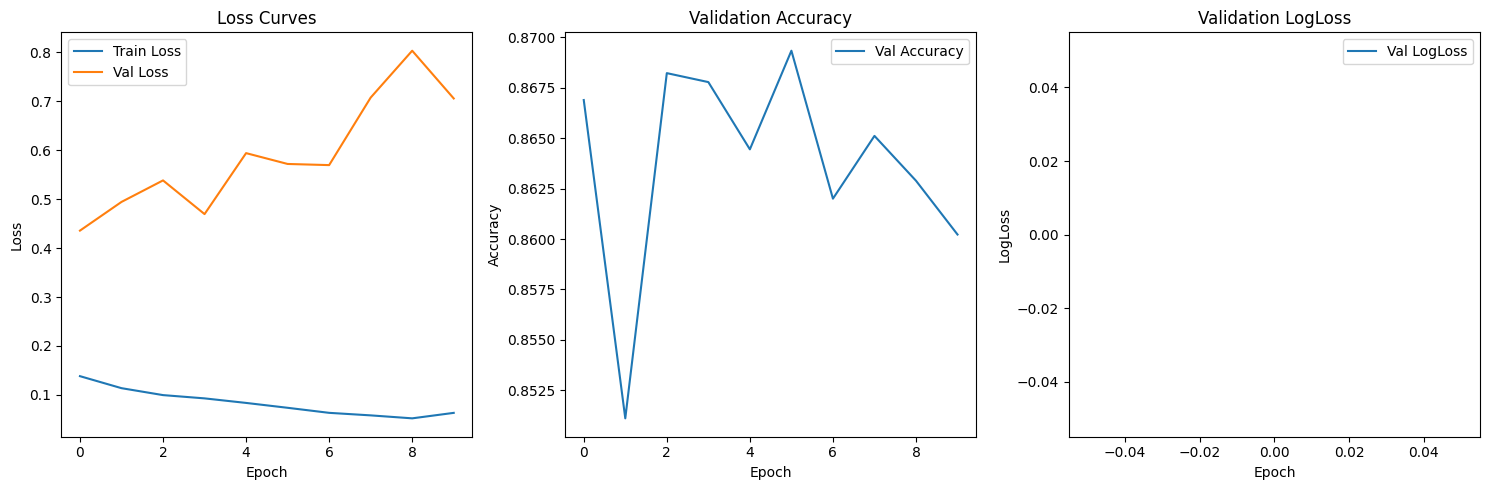

Best validation LogLoss: inf


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_title('Loss Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(val_accs, label='Val Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

axes[2].plot(val_log_losses, label='Val LogLoss')
axes[2].set_title('Validation LogLoss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('LogLoss')
axes[2].legend()

plt.tight_layout()
plt.savefig('/home/code/figures/baseline_training_curves.png')
plt.show()

print(f"Best validation LogLoss: {best_log_loss:.4f}")

In [12]:
# Load best model and make predictions on test set
model.load_state_dict(torch.load('/home/code/models/baseline_cnn_best.pth'))
model.eval()

# Get test files
test_files = os.listdir(test_dir)
test_files = [f for f in test_files if f.endswith('.jpg')]
test_files.sort(key=lambda x: int(x.split('.')[0]))  # Sort by numeric ID

print(f"Total test images: {len(test_files)}")

# Create test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = DogsCatsDataset(
    [os.path.join(test_dir, f) for f in test_files], 
    [0] * len(test_files),  # dummy labels
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Make predictions
all_test_probs = []
with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images).squeeze()
        all_test_probs.extend(outputs.cpu().numpy())

print(f"Generated {len(all_test_probs)} predictions")
print(f"Sample predictions: {all_test_probs[:5]}")

Total test images: 2500


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Testing:   1%|▏         | 1/79 [00:00<00:14,  5.57it/s]

Testing:   5%|▌         | 4/79 [00:00<00:05, 14.81it/s]

Testing:   9%|▉         | 7/79 [00:00<00:04, 17.01it/s]

Testing:  13%|█▎        | 10/79 [00:00<00:03, 19.39it/s]

Testing:  16%|█▋        | 13/79 [00:00<00:03, 20.24it/s]

Testing:  20%|██        | 16/79 [00:00<00:03, 18.70it/s]

Testing:  23%|██▎       | 18/79 [00:01<00:03, 18.97it/s]

Testing:  27%|██▋       | 21/79 [00:01<00:02, 21.30it/s]

Testing:  30%|███       | 24/79 [00:01<00:02, 19.54it/s]

Testing:  35%|███▌      | 28/79 [00:01<00:02, 20.80it/s]

Testing:  39%|███▉      | 31/79 [00:01<00:02, 22.83it/s]

Testing:  43%|████▎     | 34/79 [00:01<00:02, 21.60it/s]

Testing:  47%|████▋     | 37/79 [00:01<00:01, 23.03it/s]

Testing:  51%|█████     | 40/79 [00:02<00:01, 21.03it/s]

Testing:  54%|█████▍    | 43/79 [00:02<00:01, 22.67it/s]

Testing:  58%|█████▊    | 46/79 [00:02<00:01, 20.77it/s]

Testing:  63%|██████▎   | 50/79 [00:02<00:01, 20.66it/s]

Testing:  67%|██████▋   | 53/79 [00:02<00:01, 22.39it/s]

Testing:  71%|███████   | 56/79 [00:02<00:01, 20.44it/s]

Testing:  75%|███████▍  | 59/79 [00:02<00:00, 22.38it/s]

Testing:  78%|███████▊  | 62/79 [00:03<00:00, 20.17it/s]

Testing:  82%|████████▏ | 65/79 [00:03<00:00, 21.78it/s]

Testing:  86%|████████▌ | 68/79 [00:03<00:00, 19.06it/s]

Testing:  91%|█████████ | 72/79 [00:03<00:00, 19.86it/s]

Testing:  96%|█████████▌| 76/79 [00:03<00:00, 20.44it/s]

Testing: 100%|██████████| 79/79 [00:03<00:00, 20.90it/s]

Testing: 100%|██████████| 79/79 [00:03<00:00, 20.23it/s]

Generated 2500 predictions
Sample predictions: [0.99320483, 0.0047361488, 0.13047814, 0.95997983, 0.02167513]


In [13]:
# Create submission file
submission_df = pd.DataFrame({
    'id': [int(f.split('.')[0]) for f in test_files],
    'label': all_test_probs
})

submission_df = submission_df.sort_values('id')
submission_df.to_csv('/home/submission/submission.csv', index=False)

print("Submission file created:")
print(submission_df.head())
print(f"\nSubmission shape: {submission_df.shape}")
print(f"Prediction range: [{submission_df['label'].min():.4f}, {submission_df['label'].max():.4f}]")

Submission file created:
   id     label
0   1  0.993205
1   2  0.004736
2   3  0.130478
3   4  0.959980
4   5  0.021675

Submission shape: (2500, 2)
Prediction range: [0.0000, 1.0000]
